2018 Nov 1<br>
This notebook contains the final, published analysis of the Kepler lightcurves for the Kepler-76 system. 

In [1]:
%matplotlib inline
%load_ext autoreload
%load_ext ipycache
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

from astropy import units as u
from astropy.constants import c

from statsmodels.robust.scale import mad
from scipy.optimize import curve_fit
from numpy.random import normal

from pymc import geweke
from pymc.Matplot import geweke_plot
from corner import quantile

from PyAstronomy.modelSuite import forTrans as ft
from PyAstronomy.pyasl import isInTransit

from lightkurve import KeplerLightCurveFile, KeplerTargetPixelFile

from evilmc import evparams, evmodel, convert_Kz
from transit_utils import *
from transit_utils import bindata

from scipy.signal import lombscargle

from lmfit import minimize, Parameters, Minimizer
from emcee.autocorr import integrated_time, function
import corner

from variable_eclipses_utils import *
from BEER_curve import BEER_curve

import dill

import ipycache

K76 = Kepler76_params()

exp_time = 30./60./24.

# Official Boise State colors - https://brandstandards.boisestate.edu/colors/
BoiseState_blue = '#0033A0'
BoiseState_orange = '#D64309'

aspect_ratio = 16./9

# 2018 Dec 21 
cached = ipycache.load_vars('Analysis_of_Kepler76b_2018Dec14.pkl', ['new_BEER_out'])
new_BEER_out = cached['new_BEER_out']

dill.load_session("Analysis_of_Kepler76b_2018Dec7.db")

/Users/bjackson/anaconda2/lib/python2.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/Users/bjackson/anaconda2/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


Make plot of eclipse depth vs. num_periods to condition data

In [2]:
# Calculate BEER_curve
def calc_BEER_curve(time, params, exp_time=K76.exp_time, supersample_factor=K76.supersample_factor):
    BC = BEER_curve(time, params, exp_time=exp_time, supersample_factor=supersample_factor)
    return BC.all_signals()

def residuals(params, time, data, eps_data=1., model_to_use=calc_BEER_curve, 
              exp_time=K76.exp_time, supersample_factor=K76.supersample_factor):
    model = model_to_use(time, params, exp_time=exp_time, supersample_factor=supersample_factor)
    
    return (data - model)/eps_data

In [3]:
params = Parameters()

# Use best-fit values from Faigler et al. (2013)
params.add('per', value=K76.per.to('day').value, vary=False)
params.add('a', value=K76.a, vary=False)
params.add('b', value=K76.b, vary=False)
params.add('T0', value=K76.T0, vary=False)
params.add('baseline', value=0., min=-1000e-6, max=1000e-6)
params.add('Aellip', value=21e-6, min=-1000e-6, max=1000e-6)
params.add('Abeam', value=13e-6, min=-1000e-6, max=1000e-6)
params.add('Aplanet', value=60e-6, min=-1000e-6, max=1000e-6)
params.add('phase_shift', value=0., min=-1000e-6, max=1000e-6)
params.add('eclipse_depth', value=89e-6, min=-1000e-6, max=1000e-6)

trial_num_periods = range(1, 16)
eclipse_depths = np.array([])
eclipse_depths_errs = np.array([])
Aplanets = np.array([])
Aplanets_errs = np.array([])
redchis = np.array([])

for i in range(len(trial_num_periods)):

# Retrieve while masking out transit
    unfiltered_time, unfiltered_flux, filtered_time, filtered_flux = retreive_data(K76.saved_ep.per, num_periods=trial_num_periods[i], 
                                                             KIC=K76.KIC, params=K76.saved_ep, 
                                                             drop_outliers=True)
    folded_time = filtered_time % K76.saved_ep.per

    # Grab the out-of-transit portion
    ind = ~transit_indices(folded_time, 2.*K76.dur, K76.T0)

    time = folded_time[ind]
    data = filtered_flux[ind]
    err = np.ones_like(data) # Don't worry about scatter.
    
    out = minimize(residuals, params, args=(time, data), kws={'eps_data': err, 'model_to_use': calc_BEER_curve})

    eclipse_depths = np.append(eclipse_depths, out.params['eclipse_depth'].value)
    eclipse_depths_errs = np.append(eclipse_depths_errs, out.params['eclipse_depth'].stderr)
    
    Aplanets = np.append(Aplanets, out.params['Aplanet'].value)
    Aplanets_errs = np.append(Aplanets_errs, out.params['Aplanet'].stderr)
    
    redchis = np.append(redchis, out.redchi)

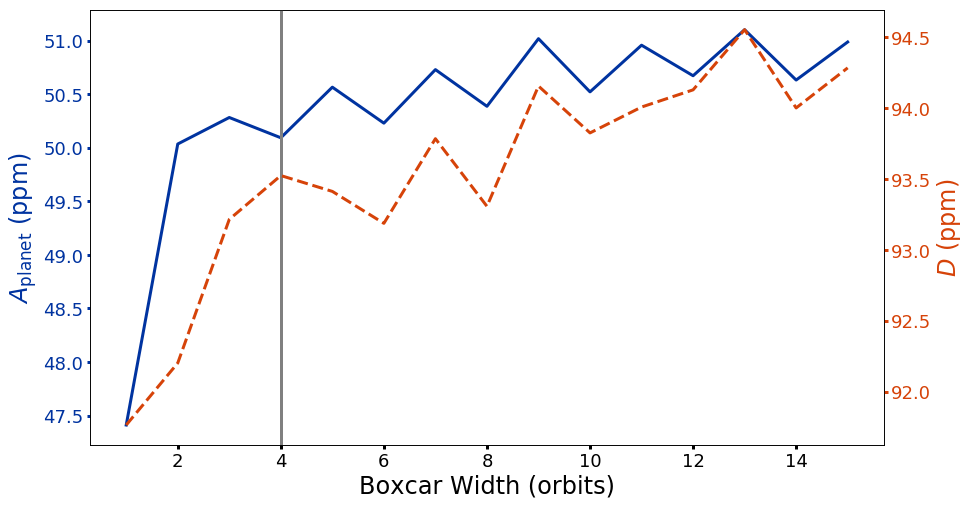

In [4]:
num_periods = 4

fig = plt.figure(figsize=(aspect_ratio*8, 8))

ax1 = fig.add_subplot(111)
ax1.plot(trial_num_periods, Aplanets*1e6, lw=3, color=BoiseState_blue)
ax1.set_xlabel("Boxcar Width (orbits)", fontsize=24)
ax1.set_ylabel("$A_{\\rm planet}$ (ppm)", color=BoiseState_blue, fontsize=24)
ax1.tick_params('y', colors=BoiseState_blue, labelsize=18)
ax1.tick_params('x', labelsize=18)

ax2 = ax1.twinx()
ax2.plot(trial_num_periods, eclipse_depths*1e6, lw=3, color=BoiseState_orange, ls='--')
ax2.set_ylabel("$D$ (ppm)", color=BoiseState_orange, fontsize=24)
ax2.tick_params('y', colors=BoiseState_orange, labelsize=18)

ax2.axvline(4, lw=3, zorder=-1, color='grey')

2018 Nov 5 - Plot of raw and conditioned data

In [20]:
num_periods = 4

unfiltered_time, unfiltered_flux, filtered_time, filtered_flux = retreive_data(K76.saved_ep.per, 
                                                                               num_periods=num_periods, 
                                                                               KIC=K76.KIC, params=K76.saved_ep, 
                                                                               drop_outliers=True)
folded_time = filtered_time % K76.saved_ep.per

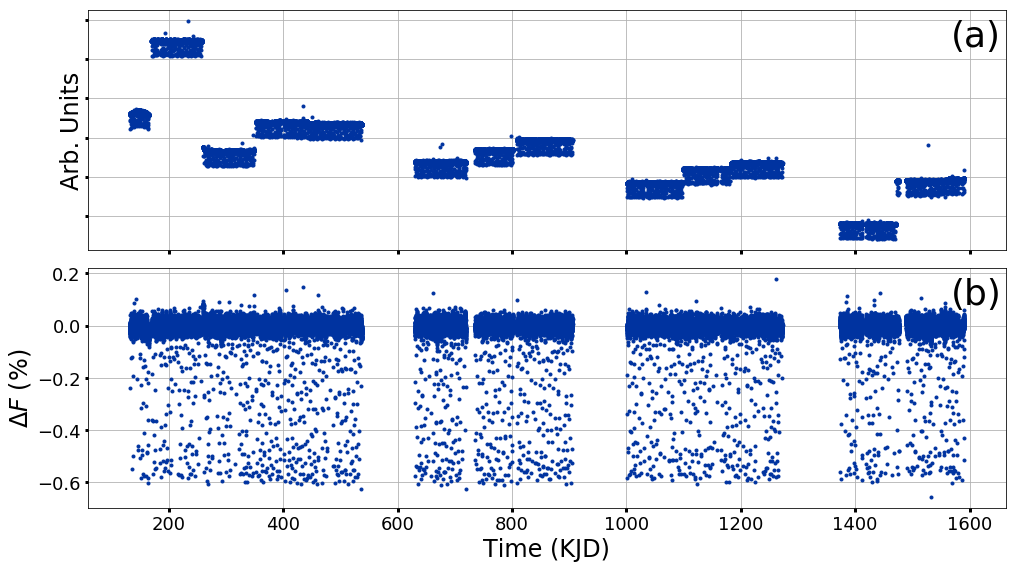

In [123]:
fig = plt.figure(figsize=(aspect_ratio*8, 8))

ax1 = fig.add_subplot(211)
ax1.grid(True)
ax1.plot(unfiltered_time, unfiltered_flux, marker='.', color=BoiseState_blue, ls='')
ax1.tick_params(labelbottom=False, labelleft=False)
ax1.annotate("(a)", xy=(0.9, 0.9), xytext=(0.94, 0.85), xycoords='axes fraction', textcoords='axes fraction',
             fontsize=36, arrowprops=None)
ax1.set_ylabel("Arb. Units", fontsize=24)

ax2 = fig.add_subplot(212)
ax2.grid(True)
ax2.plot(filtered_time, filtered_flux*100, marker='.', color=BoiseState_blue, ls='')
ax2.annotate("(b)", xy=(0.9, 0.9), xytext=(0.94, 0.85), xycoords='axes fraction', textcoords='axes fraction',
             fontsize=36, arrowprops=None)
ax2.set_xlabel("Time (KJD)", fontsize=24)
ax2.set_ylabel("$\\Delta F$ (%)", fontsize=24)
ax2.tick_params('both', labelsize=18)

plt.tight_layout()

# fig.savefig("../raw-conditioned-data_Analysis_of_Kepler76b.png", dpi=500, bbox_inches='tight')

### Check whether supersampling is necessary for fitting BEER signals

Name              Value      Min      Max   Stderr     Vary     Expr Brute_Step
Acos           4.988e-05   -0.001    0.001 1.346e-06     True     None     None
Aellip         1.27e-05   -0.001    0.001 1.381e-06     True     None     None
Asin           1.129e-05   -0.001    0.001 1.122e-06     True     None     None
T0               0.6851     -inf      inf        0    False     None     None
a                 4.525     -inf      inf        0    False     None     None
b                 0.944     -inf      inf        0    False     None     None
baseline       1.712e-06   -0.001    0.001 8.97e-07     True     None     None
eclipse_depth   8.9e-05     -inf      inf        0    False     None     None
per               1.545     -inf      inf        0    False     None     None
None
3.210220770247877e-08
(2.533376404484404, 4.992876665962327e-05)


Text(0.5,0,'Time - $T_{\\rm E}$ (KJD)')

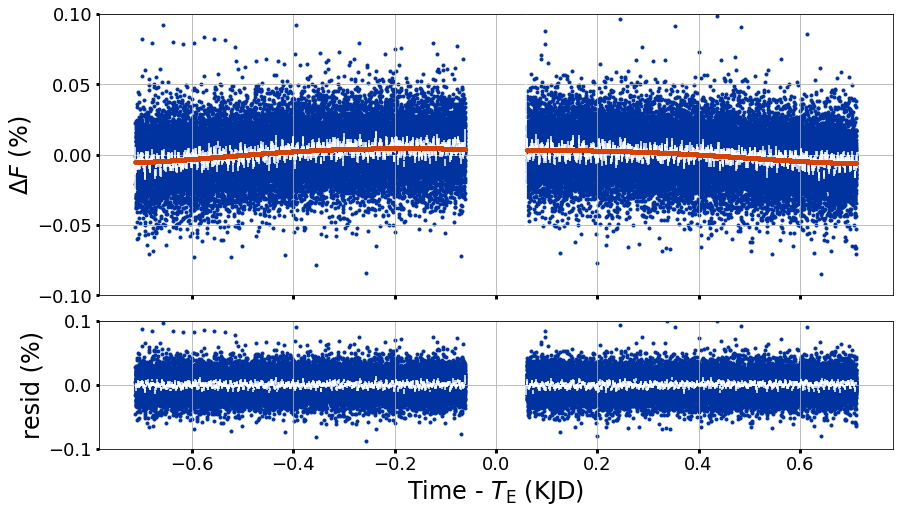

In [64]:
# 2018 Dec 13 - First check whether super-sampling is necessary for the BEER signals 
#
# This cell does NOT include supersampling!
BEER_only_params = Parameters()

# Use best-fit values from Faigler et al. (2013)
BEER_only_params.add('per', value=K76.per.to('day').value, vary=False)
BEER_only_params.add('a', value=K76.a, vary=False)
BEER_only_params.add('b', value=K76.b, vary=False)
BEER_only_params.add('T0', value=K76.T0, vary=False)
BEER_only_params.add('baseline', value=0., min=-1000e-6, max=1000e-6)
BEER_only_params.add('Aellip', value=21e-6, min=-1000e-6, max=1000e-6)
BEER_only_params.add('Asin', value=13e-6, min=-1000e-6, max=1000e-6)
BEER_only_params.add('Acos', value=60e-6, min=-1000e-6, max=1000e-6)
BEER_only_params.add('eclipse_depth', value=89e-6, vary=False)

# Grab the out-of-transit portion
ind = ~( transit_indices(folded_time, 2.*K76.dur, K76.T0) |\
         transit_indices(folded_time, 2.*K76.dur, K76.T0 + 0.5*K76.per.to('day').value) )

time = folded_time[ind]
data = filtered_flux[ind]
binned_time, binned_data, binned_err = bindata(time, data, binsize=1./60./24.)
err = np.ones_like(data) # Don't worry about scatter.

BEER_only_out = minimize(residuals, BEER_only_params, args=(time, data), 
                         kws={'eps_data': err, 'model_to_use': calc_BEER_curve, 
                             'exp_time': 0, 'supersample_factor': 1})

BEER_only_model = calc_BEER_curve(time, BEER_only_out.params)

print(BEER_only_out.params.pretty_print())
print(BEER_only_out.redchi)

# Checking whether the Asin and Acos terms give results consistent with Faigler et al. (2013)
Abeam = 13.5e-6 # Faigler et al. (2013)
phase_shift = np.arctan((Abeam - BEER_only_out.params['Asin'])/BEER_only_out.params['Acos'])/2./np.pi
Aplanet = np.sqrt((Abeam - BEER_only_out.params['Asin'])**2 + (BEER_only_out.params['Acos'])**2)
print(phase_shift*360., Aplanet)

fig = plt.figure(figsize=(aspect_ratio*8, 8))

ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax1.grid(True)

ax1.set_ylabel("$\\Delta F$ (%)", fontsize=24)
ax1.tick_params('both', labelsize=18, labelbottom=False)

# Center on eclipse
x = (time - (K76.T0 + 0.5*K76.per.to('day').value))
ind = x < -(0.5*K76.per.to('day').value)
x[ind] += K76.per.to('day').value

binned_x = (binned_time - (K76.T0 + 0.5*K76.per.to('day').value))
ind = binned_x < -(0.5*K76.per.to('day').value)
binned_x[ind] += K76.per.to('day').value

y = data*100.
ax1.plot(x, y,  
         marker='.', ls='', color=BoiseState_blue, zorder=-1)
ax1.errorbar(binned_x, binned_data*100., binned_err*100., color='white', ls='')
ax1.plot(x, BEER_only_model*100., 
         marker='.', ls='', color=BoiseState_orange)

ax1.set_ylim([-0.1, 0.1])

ax2 = plt.subplot2grid((3, 1), (2, 0), sharex=ax1)
ax2.grid(True)
ax2.plot(x, (data - BEER_only_model)*100., 
         marker='.', ls='', color=BoiseState_blue, zorder=-1)

binned_x, binned_residuals, binned_residuals_err = bindata(x, (data - BEER_only_model), binsize=1./60./24.)
ax2.errorbar(binned_x, binned_residuals*100., binned_residuals_err*100., color='white', ls='')

ax2.set_ylabel("resid (%)", fontsize=24)
ax2.tick_params('both', labelsize=18)
ax2.set_ylim([-0.1, 0.1])
ax2.set_xlabel("Time - $T_{\\rm E}$ (KJD)", fontsize=24)

Name              Value      Min      Max   Stderr     Vary     Expr Brute_Step
Acos           4.991e-05   -0.001    0.001 1.347e-06     True     None     None
Aellip         1.276e-05   -0.001    0.001 1.383e-06     True     None     None
Asin           1.132e-05   -0.001    0.001 1.122e-06     True     None     None
T0               0.6851     -inf      inf        0    False     None     None
a                 4.525     -inf      inf        0    False     None     None
b                 0.944     -inf      inf        0    False     None     None
baseline       1.838e-06   -0.001    0.001 8.97e-07     True     None     None
eclipse_depth   8.9e-05     -inf      inf        0    False     None     None
per               1.545     -inf      inf        0    False     None     None
None
3.2103106739713655e-08


Text(0.5,0,'Time - $T_{\\rm E}$ (KJD)')

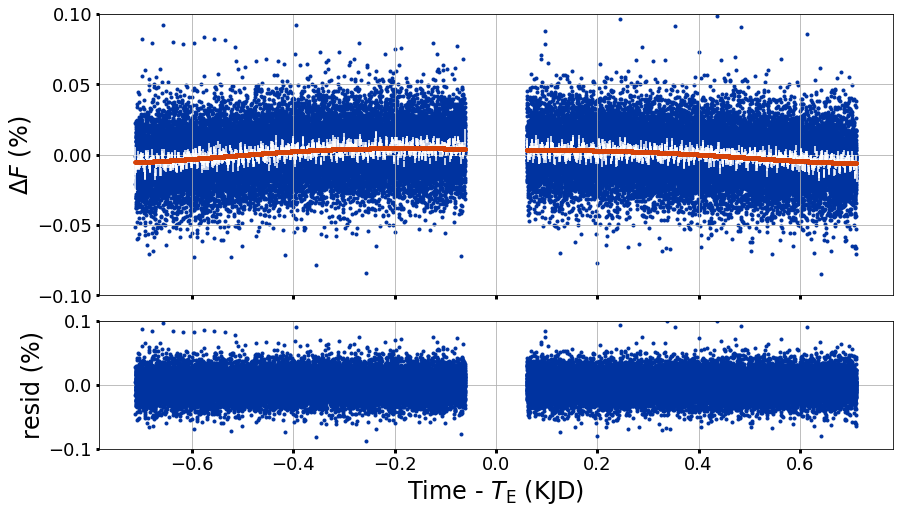

In [39]:
# This cell DOES include supersampling!
BEER_only_out = minimize(residuals, BEER_only_params, args=(time, data), 
                         kws={'eps_data': err, 'model_to_use': calc_BEER_curve})

BEER_only_model = calc_BEER_curve(time, BEER_only_out.params)

print(BEER_only_out.params.pretty_print())
print(BEER_only_out.redchi)


fig = plt.figure(figsize=(aspect_ratio*8, 8))

ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax1.grid(True)

ax1.set_ylabel("$\\Delta F$ (%)", fontsize=24)
ax1.tick_params('both', labelsize=18, labelbottom=False)

ax1.plot(x, y,  
         marker='.', ls='', color=BoiseState_blue, zorder=-1)
ax1.errorbar(binned_x, binned_data*100., binned_err*100., color='white', ls='')
ax1.plot(x, BEER_only_model*100., 
         marker='.', ls='', color=BoiseState_orange)

ax1.set_ylim([-0.1, 0.1])

ax2 = plt.subplot2grid((3, 1), (2, 0), sharex=ax1)
ax2.grid(True)
ax2.plot(x, (data - BEER_only_model)*100., 
         marker='.', ls='', color=BoiseState_blue)
ax2.set_ylabel("resid (%)", fontsize=24)
ax2.tick_params('both', labelsize=18)
ax2.set_ylim([-0.1, 0.1])
ax2.set_xlabel("Time - $T_{\\rm E}$ (KJD)", fontsize=24)

2018 Dec 12 <br>
Using LM to fit the out-of-eclipse and out-of-transit portion, you get the same fit parameters to several decimal places with and without supersampling! So to save a little time, I'm going to apply an MCMC analysis to the same data but without supersampling!

#### What if I hold Abeam fixed at Faigler et al.'s value? What values do I get for Aplanet and delta?

In [120]:
# Using Faigler's reported Abeam, what do you get?
# 2018 Dec 13 - First check whether super-sampling is necessary for the BEER signals 
#
# This cell does NOT include supersampling!
BEER_only_params = Parameters()

# Use best-fit values from Faigler et al. (2013)
BEER_only_params.add('per', value=K76.per.to('day').value, vary=False)
BEER_only_params.add('a', value=K76.a, vary=False)
BEER_only_params.add('b', value=K76.b, vary=False)
BEER_only_params.add('T0', value=K76.T0, vary=False)
BEER_only_params.add('baseline', value=0., min=-1000e-6, max=1000e-6)
BEER_only_params.add('Aellip', value=21e-6, min=-1000e-6, max=1000e-6)
BEER_only_params.add('Abeam', value=13.5e-6, vary=False)
BEER_only_params.add('Aplanet', value=60e-6, min=-1000e-6, max=1000e-6)
# Start out with Faigler's value
BEER_only_params.add('phase_shift', value=10./360, min=-0.25, max=0.25)
BEER_only_params.add('eclipse_depth', value=89e-6, vary=False)

Faigler_BEER_only_out = minimize(residuals, BEER_only_params, args=(time, data), 
                         kws={'eps_data': err, 'model_to_use': calc_BEER_curve, 
                             'exp_time': 0, 'supersample_factor': 1})

BEER_only_model = calc_BEER_curve(time, Faigler_BEER_only_out.params)
Faiglers_model = calc_BEER_curve(time, BEER_only_params)

print(Faigler_BEER_only_out.params['phase_shift'].value*360., Faigler_BEER_only_out.params['phase_shift'].stderr*360.)
print(Faigler_BEER_only_out.params['Aplanet'])

(2.5075446670478607, 1.287856459484633)
<Parameter 'Aplanet', value=4.9937546840856566e-05 +/- 1.35e-06, bounds=[-0.001:0.001]>


---

#### Fit BEER signals

Name              Value      Min      Max   Stderr     Vary     Expr Brute_Step
Acos           4.991e-05   -0.001    0.001 1.366e-06     True     None     None
Aellip         1.275e-05   -0.001    0.001 1.409e-06     True     None     None
Asin           1.133e-05   -0.001    0.001 1.116e-06     True     None     None
T0               0.6851     -inf      inf     None    False     None     None
a                 4.525     -inf      inf     None    False     None     None
b                 0.944     -inf      inf     None    False     None     None
baseline       1.835e-06   -0.001    0.001 9.128e-07     True     None     None
eclipse_depth   8.9e-05     -inf      inf     None    False     None     None
noise          0.0001792        0    0.001 6.127e-07     True     None     None
per               1.545     -inf      inf     None    False     None     None
None


Text(0.5,0,'Time - $T_{\\rm E}$ (KJD)')

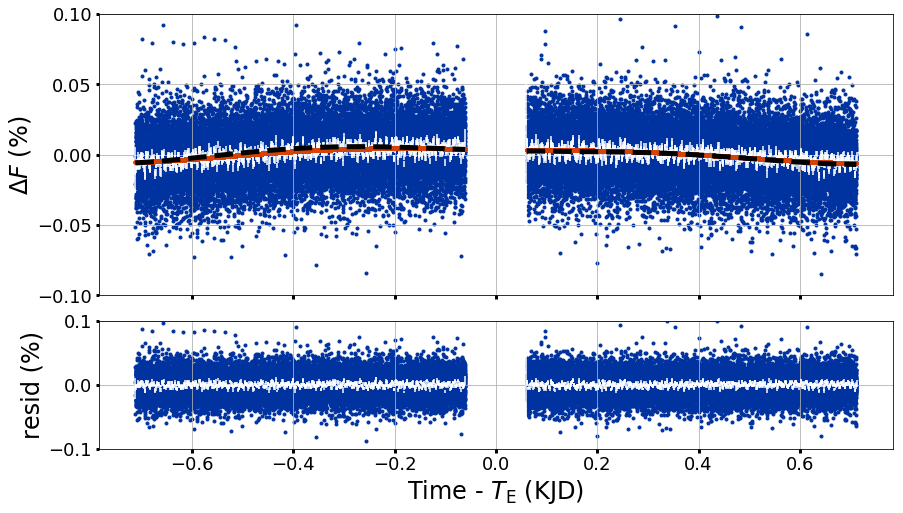

In [65]:
# 2018 Dec 13 - Fitting BEER curve using MCMC WITHOUT supersampling
def fit_BEER_lnprob(p, time, data):
    noise = p['noise']
    resids = calc_BEER_curve(time, p, exp_time=0, supersample_factor=1) - data

    return -0.5 * np.sum((resids / noise)**2 + np.log(2 * np.pi * noise**2))

BEER_only_params.add('noise', value=mad(filtered_flux), min=0., max=1000e-6)

nwalkers = 100
nsteps = 5000

# pos = np.array([(BEER_only_params[cur_key].value + 1e-5*np.random.randn(nwalkers))
#                 for cur_key in ['baseline', 'Aellip', 'Asin', 'Acos', 'noise']]).transpose()

# mini = Minimizer(fit_BEER_lnprob, BEER_only_params, fcn_args=(time, data))
# %time new_BEER_out = mini.emcee(pos=pos, nwalkers=nwalkers, steps=nsteps, params=BEER_only_params)

BEER_only_model = calc_BEER_curve(time, new_BEER_out.params, supersample_factor=1, exp_time=0)

phase_shift = np.arctan((Abeam - new_BEER_out.params['Asin'])/new_BEER_out.params['Acos'])/2./np.pi
Aplanet = np.sqrt((Abeam - new_BEER_out.params['Asin'])**2 + (new_BEER_out.params['Acos'])**2)
print(Aplanet, phase_shift)

print(new_BEER_out.params.pretty_print())

fig = plt.figure(figsize=(aspect_ratio*8, 8))

ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax1.grid(True)

ax1.set_ylabel("$\\Delta F$ (%)", fontsize=24)
ax1.tick_params('both', labelsize=18, labelbottom=False)

ax1.plot(x, y,  
         marker='.', ls='', color=BoiseState_blue, zorder=-1)

binned_time, binned_data, binned_err = bindata(time, data, binsize=1./60./24.)
binned_x = (binned_time - (K76.T0 + 0.5*K76.per.to('day').value))
ind = binned_x < -(0.5*K76.per.to('day').value)
binned_x[ind] += K76.per.to('day').value

ax1.errorbar(binned_x, binned_data*100., binned_err*100., color='white', ls='')
ax1.plot(x, BEER_only_model*100., 
         marker='.', ls='', color=BoiseState_orange)

# Include Faigler's fit
Faiglers_parameters = K76.saved_params.copy()
Faiglers_parameters['baseline'] = new_BEER_out.params['baseline'].value
Faiglers_parameters['eclipse_depth'] = new_BEER_out.params['eclipse_depth'].value
Faiglers_model = calc_BEER_curve(time, Faiglers_parameters)
srt = np.argsort(x)
# Sort so you can use a dashed line
ax1.plot(x[srt][x[srt] < 0], Faiglers_model[srt][x[srt] < 0]*100., ls='--', lw=5, color='black')
ax1.plot(x[srt][x[srt] > 0], Faiglers_model[srt][x[srt] > 0]*100., ls='--', lw=5, color='black')

ax1.set_ylim([-0.1, 0.1])

ax2 = plt.subplot2grid((3, 1), (2, 0), sharex=ax1)
ax2.grid(True)
ax2.plot(x, (data - BEER_only_model)*100., 
         marker='.', ls='', color=BoiseState_blue, zorder=-1)

_, binned_residuals, binned_residuals_err = bindata(time, (data - BEER_only_model), binsize=1./60./24.)
ax2.errorbar(binned_x, binned_residuals*100., binned_residuals_err*100., color='white', ls='')

ax2.set_ylabel("resid (%)", fontsize=24)
ax2.tick_params('both', labelsize=18)
ax2.set_ylim([-0.1, 0.1])
ax2.set_xlabel("Time - $T_{\\rm E}$ (KJD)", fontsize=24)

# fig.savefig('../BEER-curve-fit_Analysis_of_Kepler76b.png', dpi=500, bbox_inches='tight')

In [24]:
# %%cache Analysis_of_Kepler76b_2018Dec14.pkl new_BEER_out
cached = ipycache.load_vars('Analysis_of_Kepler76b_2018Dec14.pkl', ['new_BEER_out'])
new_BEER_out = cached['new_BEER_out']

# dill.dump_session('Analysis_of_Kepler76b_2018Dec14.db')
# dill.load_session('Analysis_of_Kepler76b_2018Dec14.db')

Check convergence of MCMC chains

Text(0,0.5,'noise (ppm)')

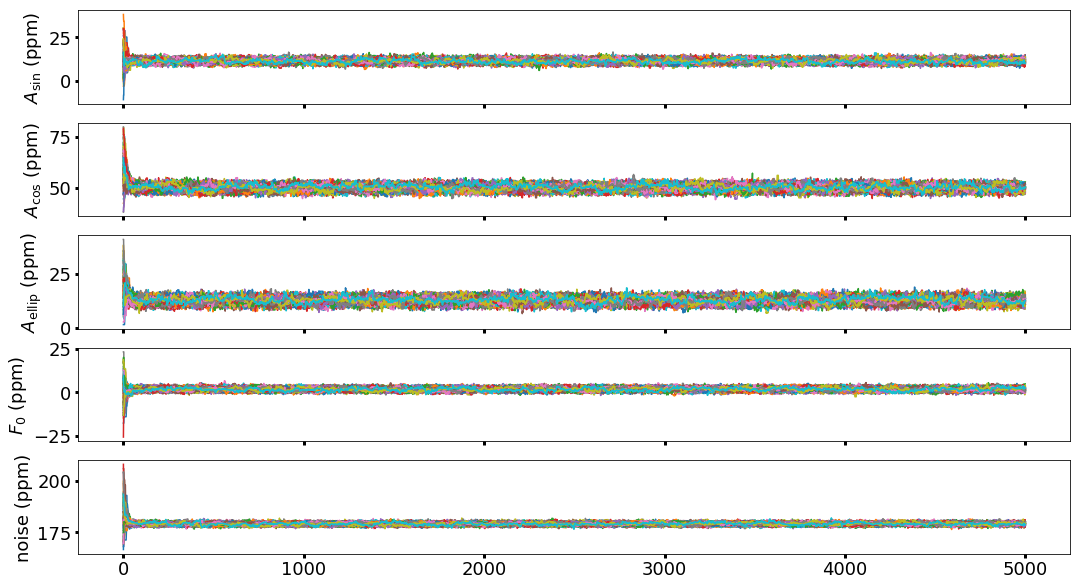

In [25]:
nwalkers = 100
nsteps = 5000

fig = plt.figure(figsize=(aspect_ratio*10, 10))

ax1 = fig.add_subplot(511)
ax1.plot(np.array(new_BEER_out.flatchain['Asin']*1e6).reshape((nwalkers, nsteps)).transpose())
ax1.tick_params(labelbottom=False, labelsize=18)
ax1.set_ylabel('$A_{\\rm sin}$ (ppm)', fontsize=18)

ax2 = fig.add_subplot(512)
ax2.plot(np.array(new_BEER_out.flatchain['Acos']*1e6).reshape((nwalkers, nsteps)).transpose())
ax2.tick_params(labelbottom=False, labelsize=18)
ax2.set_ylabel('$A_{\\rm cos}$ (ppm)', fontsize=18)

ax3 = fig.add_subplot(513, sharex=ax1)
ax3.plot(np.array(new_BEER_out.flatchain['Aellip']*1e6).reshape((nwalkers, nsteps)).transpose())
ax3.tick_params(labelbottom=False, labelsize=18)
ax3.set_ylabel('$A_{\\rm ellip}$ (ppm)', fontsize=18)

ax4 = fig.add_subplot(514)
ax4.plot(np.array(new_BEER_out.flatchain['baseline']*1e6).reshape((nwalkers, nsteps)).transpose())
ax4.tick_params(labelbottom=False, labelsize=18)
ax4.set_ylabel('$F_0$ (ppm)', fontsize=18)

ax5 = fig.add_subplot(515)
ax5.plot(np.array(new_BEER_out.flatchain['noise']*1e6).reshape((nwalkers, nsteps)).transpose())
ax5.tick_params(labelsize=18)
ax5.set_ylabel('noise (ppm)', fontsize=18)

In [26]:
burn = 0
for cur_key in ['baseline', 'Aellip', 'Asin', 'Acos', 'noise']:
    
    mean_chain = np.mean(np.array(new_BEER_out.flatchain[cur_key]).reshape((nwalkers, nsteps)).transpose(), 
                         axis=1)
    max_int_time = integrated_time(mean_chain, c=5)
    print(cur_key, max_int_time)

    burn = int(np.max([burn, 10.*max_int_time]))

# Just to be safe
if(burn < 0.5*len(mean_chain)):
    burn = int(0.5*len(mean_chain))
    
print(burn)

('baseline', 77.4177611616196)
('Aellip', 61.696394318919516)
('Asin', 44.36141292693161)
('Acos', 40.86572310475636)
('noise', 46.51667798681528)
2500


/Users/bjackson/anaconda2/lib/python2.7/site-packages/emcee/autocorr.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  acf = np.fft.ifft(f * np.conjugate(f), axis=axis)[m].real


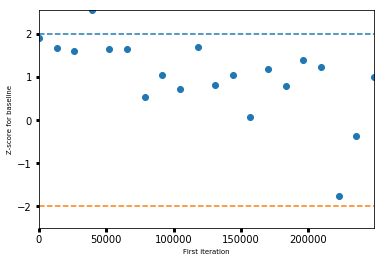

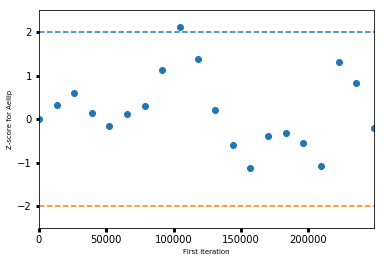

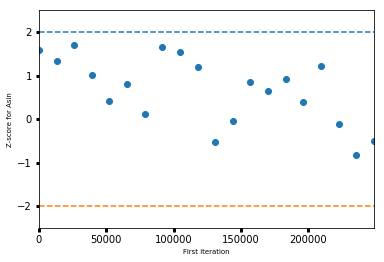

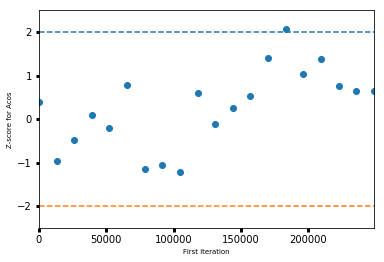

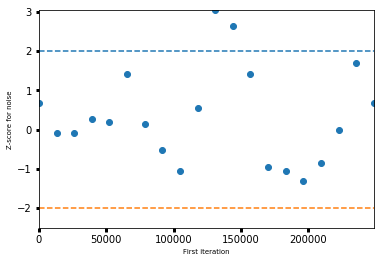

In [132]:
for cur_key in ['baseline', 'Aellip', 'Asin', 'Acos', 'noise']:
    mean_score = geweke(np.array(new_BEER_out.flatchain[cur_key])[burn:])
    geweke_plot(mean_score, name=cur_key)

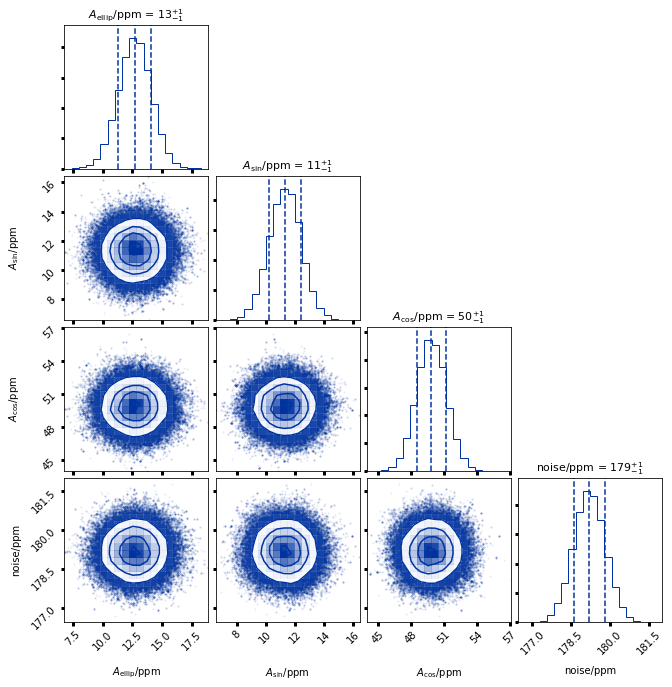

In [27]:
# Make corner plot
Aellip_chain = np.array(new_BEER_out.flatchain['Aellip']).reshape((nwalkers, nsteps)).transpose()
Asin_chain = np.array(new_BEER_out.flatchain['Asin']).reshape((nwalkers, nsteps)).transpose()
Acos_chain = np.array(new_BEER_out.flatchain['Acos']).reshape((nwalkers, nsteps)).transpose()
noise_chain = np.array(new_BEER_out.flatchain['noise']).reshape((nwalkers, nsteps)).transpose()

dists = np.array([Aellip_chain[burn:].flatten()*1e6, Asin_chain[burn:].flatten()*1e6, Acos_chain[burn:].flatten()*1e6, 
                 noise_chain[burn:].flatten()*1e6]).transpose()

Asin = np.quantile(Asin_chain[burn:], 0.5)
Asin_err = np.sqrt((np.quantile(Asin_chain[burn:], 0.84) - Asin)**2 +
                   (np.quantile(Asin_chain[burn:], 0.16) - Asin)**2
                  )

Acos = np.quantile(Acos_chain[burn:], 0.5)
Acos_err = np.sqrt((np.quantile(Acos_chain[burn:], 0.84) - Acos)**2 +
                   (np.quantile(Acos_chain[burn:], 0.16) - Acos)**2
                  )

figure = corner.corner(dists, labels=["$A_{\\rm ellip}/$ppm", "$A_{\\rm sin}/$ppm", 
                                     "$A_{\\rm cos}/$ppm", "noise/ppm"],
                       quantiles=[0.16, 0.5, 0.84], title_fmt=".0f",
                       show_titles=True, title_kwargs={"fontsize": 11}, color=BoiseState_blue)

# figure.savefig('../BEER-curve-fit-params_Analysis-of-Kepler76b.png', dpi=500, bbox_inches='tight')

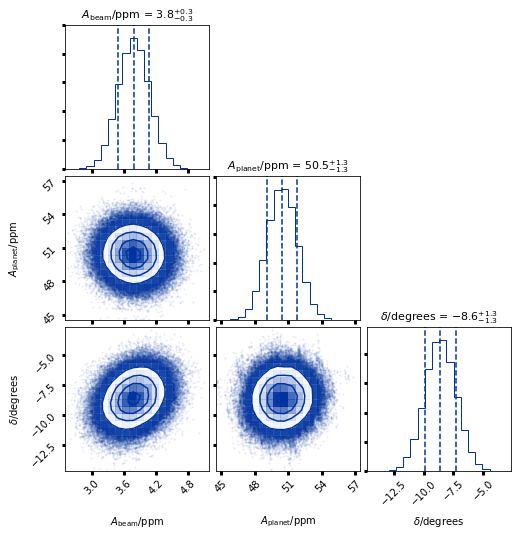

In [28]:
num_points = 250000

# Using the Abeam value suggested by Faigler et al's RV measurements, calculate Aplanet, Abeam, and phase_shift
#   KRV = 0.308 ± 0.020 km/s 
Kz = 0.308/c.to('km/s').value
Kz_err = 0.02/c.to('km/s').value

#   alpha_beam = 0.92 ± 0.04
alpha_beam = 0.92
alpha_beam_err = 0.04

# From Jackson et al. (2012) -- Abeam = alpha_beam 4 (KRV/c)
Abeam = alpha_beam*4.*Kz
Abeam_err = Abeam*np.sqrt((alpha_beam_err/alpha_beam)**2 + (Kz_err/Kz)**2)
Abeam_dist = Abeam + Abeam_err*np.random.randn(num_points)

# Checking whether the Asin and Acos terms give results consistent with Faigler et al. (2013)
tan_phase_shift_dist = (Abeam_dist - Asin_chain[burn:].flatten())/Acos_chain[burn:].flatten()
phase_shift_dist = np.arctan((Abeam_dist - Asin_chain[burn:].flatten())/Acos_chain[burn:].flatten())/2./np.pi*360.
Aplanet_dist = np.sqrt((Abeam_dist - Asin_chain[burn:].flatten())**2 + (Acos_chain[burn:].flatten())**2)

Aplanet = np.quantile(Aplanet_dist, 0.5)
Aplanet_err = np.std(Aplanet_dist)

phase_shift = np.quantile(phase_shift_dist, 0.5)
phase_shift_err = np.std(phase_shift_dist)

tan_phase_shift = np.quantile(tan_phase_shift_dist, 0.5)
tan_phase_shift_err = np.std(tan_phase_shift_dist)

dists = np.array([Abeam_dist*1e6, Aplanet_dist*1e6, phase_shift_dist]).transpose()
figure = corner.corner(dists, labels=["$A_{\\rm beam}/$ppm", "$A_{\\rm planet}/$ppm", "$\delta/$degrees"],
                       quantiles=[0.16, 0.5, 0.84], title_fmt=".1f",
                       show_titles=True, title_kwargs={"fontsize": 11}, color=BoiseState_blue)

# figure.savefig('../Aplanet-delta-fit-params_Analysis-of-Kepler76b.png', dpi=500, bbox_inches='tight')

---
Initial fit to just the transit portion using the best-fit orbital period from Faigler et al. (2013) and the Levenberg-Marquardt algorithm

In [3]:
dill.load_session("Analysis_of_Kepler76b_2018Dec7.db")

In [108]:
# Fit folded transit
initial_transit_params = Parameters()

# Use best-fit values from Faigler et al. (2013)
initial_transit_params.add('per', value=K76.per.to('day').value, vary=False)
initial_transit_params.add('a', value=K76.a, min=2., max=10.)
initial_transit_params.add('p', value=K76.Rp_over_Rs, min=0., max=0.2)
initial_transit_params.add('b', value=K76.b, min=-1., max=1.)
initial_transit_params.add('T0', value=K76.T0, min=K76.T0*0.95, max=K76.T0*1.05)
initial_transit_params.add('baseline', value=0., min=-1000e-6, max=1000e-6)

# Holding LDCs fixed at Faigler et al. (2013) values because I can't generate useful constraints on them
initial_transit_params.add('linLimb', value=K76.coeffs[0], vary=False)
initial_transit_params.add('quadLimb', value=K76.coeffs[1], vary=False)

transit_ind = transit_indices(folded_time, 2.*K76.dur, K76.saved_params['T0'])
time = folded_time[transit_ind]

# 2018 Nov 16 - BEER only model
BEER_only_model = calc_BEER_curve(time, BEER_only_out.params)
data = filtered_flux[transit_ind] - BEER_only_model
# Initial estimate of scatter
err = mad(filtered_flux[~transit_ind])*np.ones_like(time)

out = minimize(residuals, initial_transit_params, args=(time, data), 
               kws={'eps_data': err, 'model_to_use': fit_transit})
print(out.params.pretty_print())
print(out.redchi)

Name         Value      Min      Max   Stderr     Vary     Expr Brute_Step
T0           0.685   0.6508   0.7193 2.606e-05     True     None     None
a            5.116        2       10  0.05499     True     None     None
b           0.9072       -1        1 0.002859     True     None     None
baseline  -1.078e-05   -0.001    0.001 5.009e-06     True     None     None
linLimb      0.313     -inf      inf        0    False     None     None
p          0.08463        0      0.2 0.0005153     True     None     None
per          1.545     -inf      inf        0    False     None     None
quadLimb     0.304     -inf      inf        0    False     None     None
None
1.2758892376101258


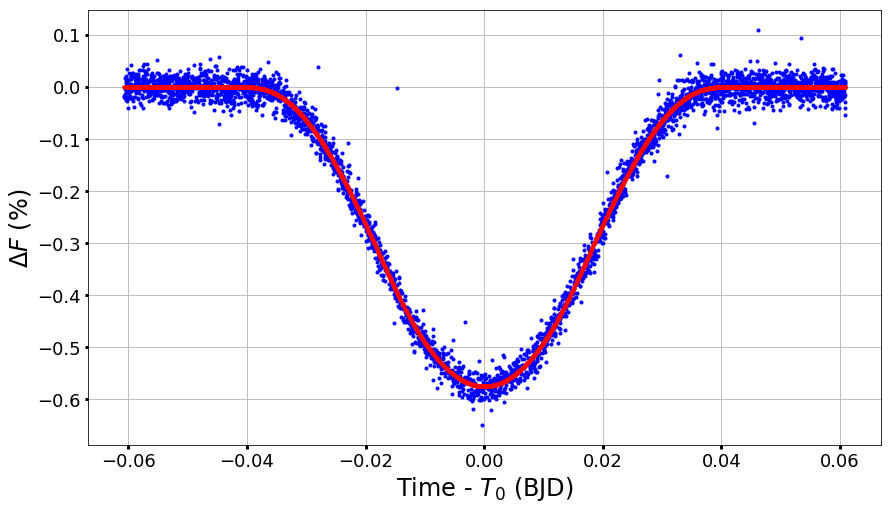

In [109]:
fig = plt.figure(figsize=(aspect_ratio*8, 8))
ax = fig.add_subplot(111)
ax.grid(True)
ax.plot(time - out.params['T0'], data*100, 'b.')
ax.plot(time - out.params['T0'], fit_transit(time, out.params)*100, 'r.')

ax.set_xlabel("Time - $T_{\\rm 0}$ (BJD)", fontsize=24)
ax.set_ylabel("$\\Delta F$ (%)", fontsize=24)
ax.tick_params('both', labelsize=18)

In [9]:
# Checking how the fit parameters vary if I use limb-darkening coefficients from Espinoza & Jordan (2015)
# http://adsabs.harvard.edu/abs/2015MNRAS.450.1879E

# Use best-fit values from Faigler et al. (2013)
initial_transit_params.add('per', value=K76.per.to('day').value, vary=False)
initial_transit_params.add('a', value=K76.a, min=2., max=10.)
initial_transit_params.add('p', value=K76.Rp_over_Rs, min=0., max=0.2)
initial_transit_params.add('b', value=K76.b, min=-1., max=1.)
initial_transit_params.add('T0', value=K76.T0, min=K76.T0*0.95, max=K76.T0*1.05)
initial_transit_params.add('baseline', value=0., min=-1000e-6, max=1000e-6)

# From Kepler76_output_file.dat - 
# Kepler-76  A100  KpHiRes
# Teff=6250.0K  log(g)=4.0  [M/H]=-0.1  vturb=2.0
initial_transit_params['linLimb'].value = 0.32587116
initial_transit_params['quadLimb'].value = 0.30272132

transit_ind = transit_indices(folded_time, 2.*K76.dur, K76.saved_params['T0'])

time = folded_time[transit_ind]
data = filtered_flux[transit_ind]
# Initial estimate of scatter
err = mad(filtered_flux[~transit_ind])*np.ones_like(time)

out = minimize(residuals, initial_transit_params, args=(time, data), 
               kws={'eps_data': err, 'model_to_use': fit_transit})
print(out.params.pretty_print())
print(out.redchi)

Name         Value      Min      Max   Stderr     Vary     Expr Brute_Step
T0           0.685   0.6508   0.7193 2.606e-05     True     None     None
a            5.114        2       10  0.05474     True     None     None
b           0.9069       -1        1 0.002866     True     None     None
baseline  -4.433e-05   -0.001    0.001 5.013e-06     True     None     None
linLimb     0.3259     -inf      inf        0    False     None     None
p          0.08488        0      0.2 0.0005234     True     None     None
per          1.545     -inf      inf        0    False     None     None
quadLimb    0.3027     -inf      inf        0    False     None     None
None
1.2772928754771382


In [10]:
# Checking how the fit parameters vary if I use limb-darkening coefficients from Espinoza & Jordan (2015)
# http://adsabs.harvard.edu/abs/2015MNRAS.450.1879E

# Use best-fit values from Faigler et al. (2013)
initial_transit_params.add('per', value=K76.per.to('day').value, vary=False)
initial_transit_params.add('a', value=K76.a, min=2., max=10.)
initial_transit_params.add('p', value=K76.Rp_over_Rs, min=0., max=0.2)
initial_transit_params.add('b', value=K76.b, min=-1., max=1.)
initial_transit_params.add('T0', value=K76.T0, min=K76.T0*0.95, max=K76.T0*1.05)
initial_transit_params.add('baseline', value=0., min=-1000e-6, max=1000e-6)

# From Kepler76_output_file.dat - 
# Kepler-76  P100  KpHiRes
# Teff=6300.0K  log(g)=4.0  [M/H]=0.0  vturb=2.0
initial_transit_params['linLimb'].value = 0.44916238
initial_transit_params['quadLimb'].value = 0.19578540

transit_ind = transit_indices(folded_time, 2.*K76.dur, K76.saved_params['T0'])

time = folded_time[transit_ind]
data = filtered_flux[transit_ind]
# Initial estimate of scatter
err = mad(filtered_flux[~transit_ind])*np.ones_like(time)

out = minimize(residuals, initial_transit_params, args=(time, data), 
               kws={'eps_data': err, 'model_to_use': fit_transit})
print(out.params.pretty_print())
print(out.redchi)

Name         Value      Min      Max   Stderr     Vary     Expr Brute_Step
T0           0.685   0.6508   0.7193 2.606e-05     True     None     None
a            5.141        2       10  0.05574     True     None     None
b           0.9055       -1        1 0.002953     True     None     None
baseline  -4.417e-05   -0.001    0.001 5.019e-06     True     None     None
linLimb     0.4492     -inf      inf        0    False     None     None
p          0.08573        0      0.2 0.0005419     True     None     None
per          1.545     -inf      inf        0    False     None     None
quadLimb    0.1958     -inf      inf        0    False     None     None
None
1.2772196299273708


At least according to Levenberg-Marquardt, I get the same transit parameters (to within uncertainties) for all three sets of limb-darkening parameters.

---

2018 Nov 6 - Fit the mid-transit times

In [111]:
def fit_line_lnprob(p, x, y):
    noise = p['noise']
    resids = (y - (p['slope']*x + p['intercept']))
    return -0.5 * np.sum((resids / noise)**2 + np.log(2 * np.pi * noise**2))

def fit_quad_lnprob(p, x, y):
    noise = p['noise']
    resids = (y - (p['a']*x**2 + p['b']*x + p['c']))
    return -0.5 * np.sum((resids / noise)**2 + np.log(2 * np.pi * noise**2))

# Restore previous best-fit parameters
each_transit_params = out.params.copy()

# Hold some parameters fixed - One or two data points in transit does not allow these parameters to be fit!
each_transit_params['a'].vary = False
each_transit_params['p'].vary = False
each_transit_params['b'].vary = False

# Collect each orbit, one at a time and fit mid-transit time
cur_orb = -1
num_orb = np.array([])
midtransit_times = np.array([])
midtransit_times_err = np.array([])
num_points_in_transit = np.array([])
ind = (filtered_time >= np.min(filtered_time)) &\
        (filtered_time < np.min(filtered_time) + each_transit_params['per'].value)
time = filtered_time[ind]
mn_time = np.min(time)

while(mn_time <= np.max(filtered_time)):
# while(mn_time <= np.min(filtered_time) + 5.*each_transit_params['per'].value):
    
    ind = (filtered_time >= mn_time) & (filtered_time < mn_time + each_transit_params['per'].value)
    mn_time += each_transit_params['per'].value
    cur_orb += 1

    time = filtered_time[ind]
    folded_time = filtered_time[ind] % each_transit_params['per'].value
    data = filtered_flux[ind]
    
    # Mask the transit and estimate uncertainties from standard deviation of remaining points
    folded_time = time % each_transit_params['per']
    dur = transit_duration(each_transit_params)
    non_transit_ind = ~isInTransit(folded_time, each_transit_params['T0'], each_transit_params['per'], 0.5*dur, 
                                   boolOutput=True)
    err = np.ones_like(data)*mad(data[non_transit_ind])
    
    # Check there's at least one point in transit
    if(data[~non_transit_ind].size == 0):
        continue
    
    # Adjust initial guess
    new_T0 = K76.T0 + np.floor(np.min(time)/each_transit_params['per'].value)*each_transit_params['per'].value
    each_transit_params['T0'].set(value=new_T0, min=new_T0*0.95, max=new_T0*1.05)
    
    new_out = minimize(residuals, each_transit_params, args=(time, data), 
               kws={'eps_data': err, 'model_to_use': fit_transit})

    num_orb = np.append(num_orb, cur_orb)
    midtransit_times = np.append(midtransit_times, new_out.params['T0'].value)
    cur_err = new_out.params['T0'].stderr
    if(cur_err is None):
        cur_err = np.nan 
    midtransit_times_err = np.append(midtransit_times_err, cur_err)

ind = ~np.isnan(midtransit_times_err)
x = num_orb[ind]
y = midtransit_times[ind] - new_out.params['per'].value*num_orb[ind] - np.min(midtransit_times[ind])
yerr = midtransit_times_err[ind] 
    
# Fit straight line to mid-transit times
line_fit_params = Parameters()
line_fit_params.add_many(('slope', new_out.params['per'].value, True, 
                         new_out.params['per'].value*0.95, new_out.params['per'].value*1.05, None, False), 
                         ('intercept', np.min(midtransit_times), True,
                         np.min(midtransit_times)*0.95, np.min(midtransit_times)*1.05, None, False), 
                         ('noise', np.median(yerr), True,
                         0., 10.*np.max(yerr), None, False))

# mini = Minimizer(fit_line_lnprob, line_fit_params, fcn_args=(num_orb, midtransit_times))
# %time line_out = mini.emcee(burn=300, steps=1000, params=line_fit_params)

# LM analysis instead
# line_out = minimize(fit_line, line_fit_params, args=(num_orb[ind], midtransit_times[ind]), 
#            kws={'err': midtransit_times_err[ind]})
# print(line_out.redchi, line_out.aic, line_out.bic)

print("Linear Fit")
print(line_out.params.pretty_print(precision=8))
print(integrated_time(line_out.flatchain['slope']), integrated_time(line_out.flatchain['intercept']))
# From Faigler et al. (2013) - Subtracting off Kepler's T0 offset
Faigler_T0 = 2454966.54811 - 2454833. - 1.54492875 #Last number is Faigler's orbital period
print("Faigler's T0: ", Faigler_T0)
print("\n")

# Fit quadratic to mid-transit times
quad_fit_params = Parameters()
quad_fit_params.add_many(('b', new_out.params['per'].value, True, 
                         new_out.params['per'].value*0.95, new_out.params['per'].value*1.05, None, False), 
                         ('c', np.min(midtransit_times), True,
                         np.min(midtransit_times)*0.95, np.min(midtransit_times)*1.05, None, False),
                         ('a', -0.1, True,
                         -1., 1., None, False), 
                         ('noise', np.median(yerr), True,
                         0., 10.*np.max(yerr), None, False))

# LM analysis instead
# quad_out = minimize(fit_quad, quad_fit_params, args=(num_orb[ind], midtransit_times[ind]), 
#            kws={'err': midtransit_times_err[ind]})
# print(quad_out.redchi, quad_out.aic, quad_out.bic)

# mini = Minimizer(fit_quad_lnprob, quad_fit_params, fcn_args=(num_orb, midtransit_times))
# %time quad_out = mini.emcee(burn=1500, steps=5000, params=quad_fit_params)

print("Quad Fit")
print(quad_out.params.pretty_print(precision=8))
print(integrated_time(quad_out.flatchain['a']), integrated_time(quad_out.flatchain['b']), 
      integrated_time(quad_out.flatchain['c']))
# # # And finally check for any periodic signals -
# # #  https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lombscargle.html
# nout = 10000
# min_freq = 1./np.min(midtransit_times[1:] - midtransit_times[0:-1])
# max_freq = 1./(np.max(midtransit_times) - np.min(midtransit_times[0:-1]))
# f = np.linspace(min_freq, max_freq, nout)
# pgram = lombscargle(midtransit_times, midtransit_times - lin_fit, f)

# # Largest peak barely above the other peaks, suggesting no periodicity
# plt.semilogy(f, pgram)

/Users/bjackson/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


Linear Fit
Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
intercept  132.00396 125.40366 138.60404 5.0120096e-05     True     None    False
noise      0.0006471336        0 0.012336858 1.8191525e-05     True     None    False
slope      1.5449287 1.4676823 1.6221752 9.3493531e-08     True     None    False
None
(45.58213763593051, 48.34109392863476)
("Faigler's T0: ", 132.00318124985785)


Quad Fit
Name      Value      Min      Max   Stderr     Vary     Expr Brute_Step
a      2.0923311e-10       -1        1 3.70078e-10     True     None    False
b      1.5449285 1.4676823 1.6221752 3.5750062e-07     True     None    False
c      132.00399 125.40366 138.60404 7.1281391e-05     True     None    False
noise  0.00064822845        0 0.012336858 1.8247979e-05     True     None    False
None
(46.11712455659581, 46.69645577208952, 47.17143846144203)


Text(0.25,0.75,'$P = $1.54492871 $\\pm$ 9$\\times 10^{-8}$ days\n$T_0 = $132.00396 $\\pm$ 5$\\times 10^{-5}$ KJD')

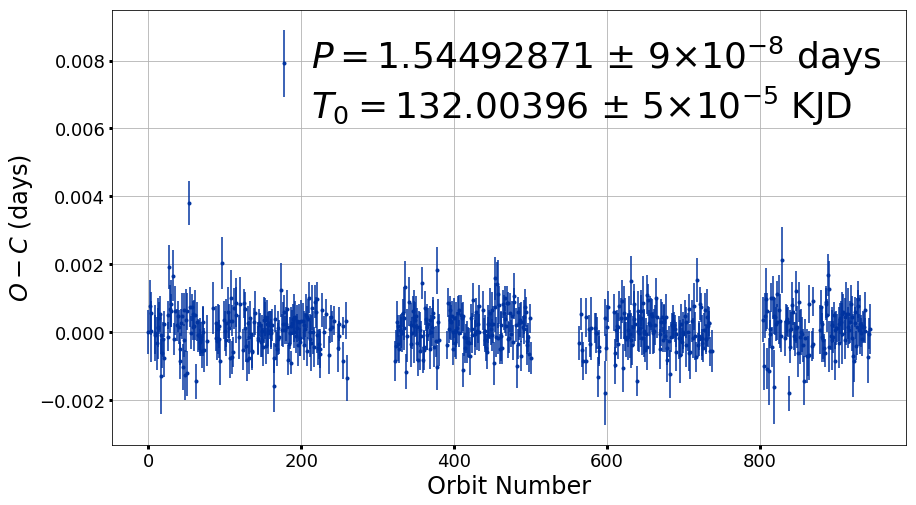

In [112]:
fig = plt.figure(figsize=(aspect_ratio*8, 8))
ax = fig.add_subplot(111)
ax.grid(True)
plt.errorbar(x, y, yerr=yerr, marker='.', ls='', color=BoiseState_blue)

ax.set_xlabel("Orbit Number", fontsize=24)
ax.set_ylabel("$O - C$ (days)", fontsize=24)
ax.tick_params('both', labelsize=18)

period_err_exp = np.floor(np.log10(line_out.params['slope'].stderr))
period_err_digit = np.floor(line_out.params['slope'].stderr/10**(period_err_exp))

T0_err_exp = np.floor(np.log10(line_out.params['intercept'].stderr))
T0_err_digit = np.floor(line_out.params['intercept'].stderr/10**(T0_err_exp))

ax.annotate(("$P = $%.8f $\\pm$ %1d$\\times 10^{%d}$ days\n" +\
             "$T_0 = $%.5f $\\pm$ %1d$\\times 10^{%d}$ KJD") % 
            (line_out.params['slope'].value, period_err_digit, period_err_exp, 
             line_out.params['intercept'].value, T0_err_digit, T0_err_exp), 
            xy=(0.9, 0.9), xytext=(0.25, 0.75), xycoords='axes fraction', textcoords='axes fraction',
            fontsize=36, arrowprops=None)

# fig.savefig("../TTVs_Analysis_of_Kepler76b.png", dpi=500, bbox_inches='tight')

In [75]:
# Check mid-transit time uncertainties using MCMC analysis

# Check transit ephemeris using ONLY the transit signal
def lnprob(p, time, data, model_to_use=fit_transit):
    noise = p['noise']
    resids = residuals(p, time, data, model_to_use=fit_transit)
    return -0.5 * np.sum((resids / noise)**2 + np.log(2 * np.pi * noise**2))

# Restore previous best-fit parameters
MCMC_each_transit_params = out.params.copy()

# Hold some parameters fixed - One or two data points in transit does not allow these parameters to be fit!
MCMC_each_transit_params['a'].vary = False
MCMC_each_transit_params['p'].vary = False
MCMC_each_transit_params['b'].vary = False

MCMC_each_transit_params.add('noise', value=mad(filtered_flux), vary=True, min=-0.01, max=0.1)

#Collect each orbit, one at a time and fit mid-transit time
cur_orb = -1
orbit_num = 2

ind = (filtered_time >= np.min(filtered_time)) &\
        (filtered_time < np.min(filtered_time) + each_transit_params['per'].value)
time = filtered_time[ind]
mn_time = np.min(time) + orbit_num*each_transit_params['per'].value

ndim, nwalkers = len(MCMC_each_transit_params.keys()), 100

# while(mn_time <= np.max(filtered_time)):
while(mn_time < np.min(filtered_time) + (orbit_num + 1)*each_transit_params['per'].value):
    
    ind = (filtered_time >= mn_time) & (filtered_time < mn_time + each_transit_params['per'].value)
    mn_time += each_transit_params['per'].value
    cur_orb += 1

    time = filtered_time[ind]
    folded_time = filtered_time[ind] % each_transit_params['per'].value
    data = filtered_flux[ind]
    
    # Mask the transit and estimate uncertainties from standard deviation of remaining points
    folded_time = time % each_transit_params['per']
    dur = transit_duration(each_transit_params)
    non_transit_ind = ~isInTransit(folded_time, MCMC_each_transit_params['T0'], MCMC_each_transit_params['per'], 
                                   0.5*dur, boolOutput=True)
    MCMC_each_transit_params['noise'].value = mad(data[non_transit_ind])
    
    # Check there's at least one point in transit
    if(data[~non_transit_ind].size == 0):
        continue
    
    # Adjust initial guess
    new_T0 = K76.T0 +\
        np.floor(np.min(time)/MCMC_each_transit_params['per'].value)*MCMC_each_transit_params['per'].value
    MCMC_each_transit_params['T0'].set(value=new_T0, min=new_T0*0.95, max=new_T0*1.05)

    mini = Minimizer(lnprob, MCMC_each_transit_params, fcn_args=(time, data), fcn_kws={'model_to_use': fit_transit})
    
    # Initialize walkers in a ball around the best-fit position 
    pos = np.array([MCMC_each_transit_params[cur_key].value*\
                    (1. + 1e-4*np.random.randn(nwalkers))
                    for cur_key in ['T0', 'baseline', 'noise']]).transpose()

    %time res = mini.emcee(pos=pos, burn=300, steps=1000, params=MCMC_each_transit_params)
    
    print(res.params.pretty_print())

CPU times: user 31.6 s, sys: 32.7 ms, total: 31.6 s
Wall time: 31.6 s
Name         Value      Min      Max   Stderr     Vary     Expr Brute_Step
T0           135.1    128.3    141.8 0.0007928     True     None     None
a            5.114        2       10     None    False     None     None
b           0.9072       -1        1     None    False     None     None
baseline  2.136e-05   -0.001    0.001 2.03e-05     True     None     None
linLimb      0.313     -inf      inf     None    False     None     None
noise     0.0001712    -0.01      0.1 1.457e-05     True     None     None
p          0.08464        0      0.2     None    False     None     None
per          1.545     -inf      inf     None    False     None     None
quadLimb     0.304     -inf      inf     None    False     None     None
None


2018 Nov 8 - Now to explore transit fit posteriors using MCMC

In [80]:
# Re-condition data using new period
new_T0 = line_out.params['intercept'].value % line_out.params['slope'].value

new_transit_params = {'per': line_out.params['slope'].value, 'p': K76.saved_ep.p, 'b': K76.saved_ep.b, 
                     'a': K76.saved_ep.a, 'T0': new_T0}

unfiltered_time, unfiltered_flux, filtered_time, filtered_flux = retreive_data(line_out.params['slope'].value, 
                                                                               num_periods=num_periods, KIC=K76.KIC, 
                                                                               params=new_transit_params, 
                                                                               drop_outliers=True)
folded_time = filtered_time % line_out.params['slope'].value

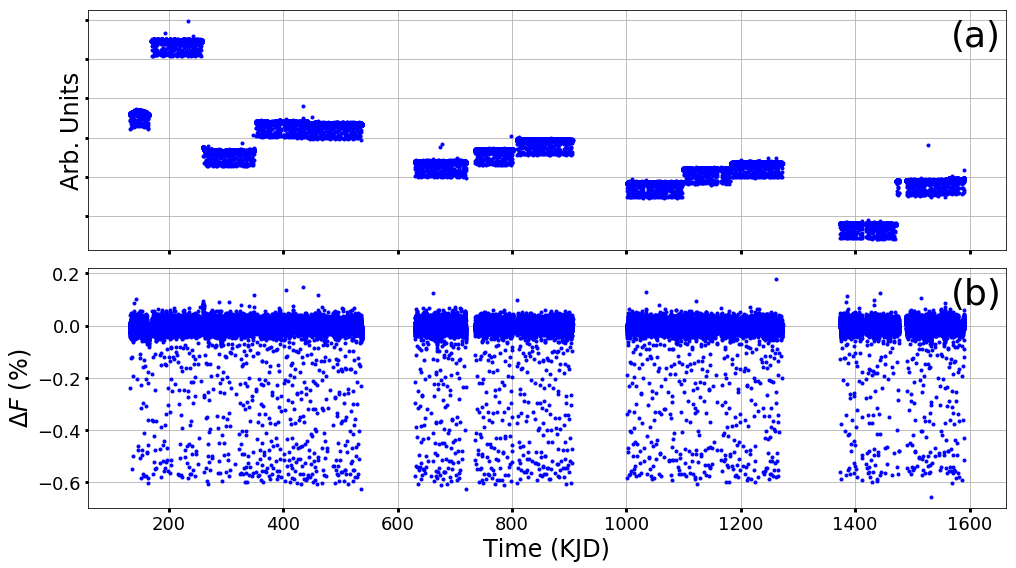

In [81]:
fig = plt.figure(figsize=(aspect_ratio*8, 8))

ax1 = fig.add_subplot(211)
ax1.grid(True)
ax1.plot(unfiltered_time, unfiltered_flux, 'b.')
ax1.tick_params(labelbottom=False, labelleft=False)
ax1.annotate("(a)", xy=(0.9, 0.9), xytext=(0.94, 0.85), xycoords='axes fraction', textcoords='axes fraction',
             fontsize=36, arrowprops=None)
ax1.set_ylabel("Arb. Units", fontsize=24)

ax2 = fig.add_subplot(212)
ax2.grid(True)
ax2.plot(filtered_time, filtered_flux*100, 'b.')
ax2.annotate("(b)", xy=(0.9, 0.9), xytext=(0.94, 0.85), xycoords='axes fraction', textcoords='axes fraction',
             fontsize=36, arrowprops=None)
ax2.set_xlabel("Time (KJD)", fontsize=24)
ax2.set_ylabel("$\\Delta F$ (%)", fontsize=24)
ax2.tick_params('both', labelsize=18)

plt.tight_layout()

In [101]:
def fit_transit_lnprob(p, time, data):
    noise = p['noise']
    resids = fit_transit(time, p) - data
    return -0.5 * np.sum((resids / noise)**2 + np.log(2 * np.pi * noise**2))

# Fit folded transit
new_transit_params = Parameters()

# Use best-fit values from Faigler et al. (2013)
new_transit_params.add('per', value=line_out.params['slope'].value, vary=False)
new_transit_params.add('a', value=out.params['a'], min=2., max=10.)
new_transit_params.add('p', value=out.params['p'], min=0., max=0.2)
new_transit_params.add('b', value=out.params['b'], min=-1., max=1.)
new_transit_params.add('T0', value=new_T0, min=new_T0*0.95, max=new_T0*1.05)
new_transit_params.add('baseline', value=10e-6, min=-1000e-6, max=1000e-6)

# Holding LDCs fixed at Faigler et al. (2013) values because I can't generate useful constraints on them
new_transit_params.add('linLimb', value=K76.coeffs[0], vary=False)
new_transit_params.add('quadLimb', value=K76.coeffs[1], vary=False)

transit_ind = transit_indices(folded_time, 2.*K76.dur, new_T0)
time = folded_time[transit_ind]
data = filtered_flux[transit_ind]

# Initial estimate of noise
noise = mad(filtered_flux[~transit_ind])
new_transit_params.add('noise', value=noise, min=0., max=10.*noise)

# 2018 Nov 13 - Trying to run another set of MCMC analyses using the results from the previous run
nwalkers = 100
nsteps = 4000
pos = np.array([mens[cur_key]*\
                (1. + stds[cur_key]*np.random.randn(nwalkers))
                for cur_key in ['a', 'p', 'b', 'T0', 'baseline', 'noise']]).transpose()
# mini = Minimizer(fit_transit_lnprob, new_transit_params, fcn_args=(time, data))
# %time new_transit_out = mini.emcee(pos=pos, nwalkers=nwalkers, steps=nsteps, params=new_transit_params)
%time new_transit_out = mini.emcee(nwalkers=nwalkers, steps=nsteps, params=new_transit_params, reuse_sampler=True)

print(new_transit_out.params.pretty_print())

CPU times: user 33min 17s, sys: 1min 26s, total: 34min 43s
Wall time: 34min 47s
Name         Value      Min      Max   Stderr     Vary     Expr Brute_Step
T0           0.685   0.6508   0.7193 2.609e-05     True     None     None
a            5.103        2       10  0.05972     True     None     None
b           0.9078       -1        1 0.003135     True     None     None
baseline  -6.902e-05   -0.001    0.001 5.056e-06     True     None     None
linLimb      0.313     -inf      inf     None    False     None     None
noise     0.0001994        0 0.001766 2.33e-06     True     None     None
p          0.08476        0      0.2 0.0005832     True     None     None
per          1.545     -inf      inf     None    False     None     None
quadLimb     0.304     -inf      inf     None    False     None     None
None


Text(0,0.5,'noise (ppm)')

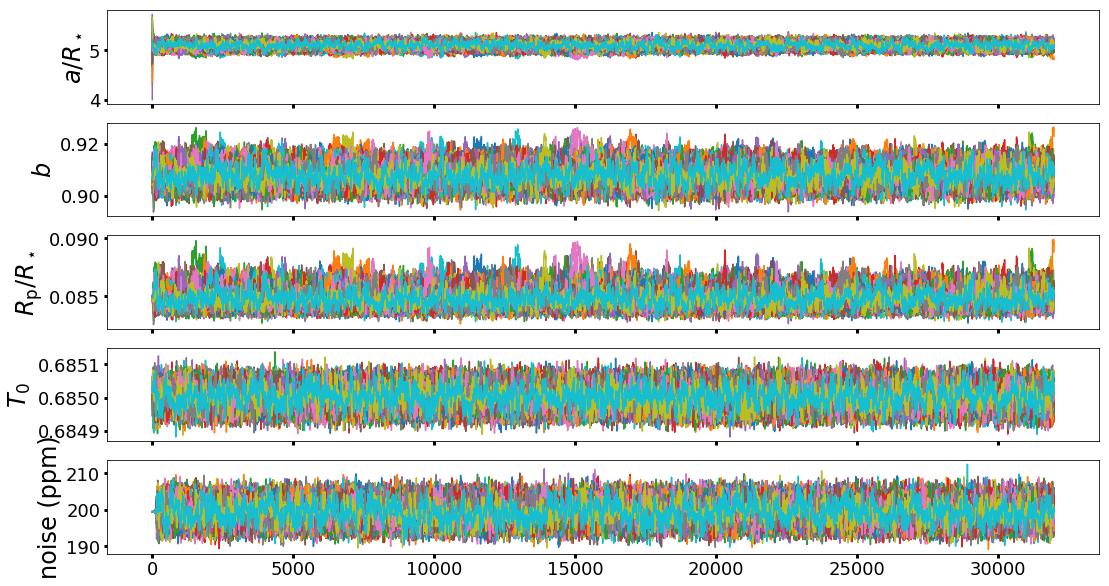

In [103]:
fig = plt.figure(figsize=(aspect_ratio*10, 10))

nsteps = 32000

ax1 = fig.add_subplot(511)
ax1.plot(np.array(new_transit_out.flatchain['a']).reshape((nwalkers, nsteps)).transpose())
ax1.tick_params(labelbottom=False, labelsize=18)
ax1.set_ylabel('$a/R_\star$', fontsize=24)

ax2 = fig.add_subplot(512, sharex=ax1)
ax2.plot(np.array(new_transit_out.flatchain['b']).reshape((nwalkers, nsteps)).transpose())
ax2.tick_params(labelbottom=False, labelsize=18)
ax2.set_ylabel('$b$', fontsize=24)

ax3 = fig.add_subplot(513)
ax3.plot(np.array(new_transit_out.flatchain['p']).reshape((nwalkers, nsteps)).transpose())
ax3.tick_params(labelbottom=False, labelsize=18)
ax3.set_ylabel('$R_{\\rm p}/R_\star$', fontsize=24)

ax4 = fig.add_subplot(514)
ax4.plot(np.array(new_transit_out.flatchain['T0']).reshape((nwalkers, nsteps)).transpose())
ax4.tick_params(labelbottom=False, labelsize=18)
ax4.set_ylabel('$T_0$', fontsize=24)

ax5 = fig.add_subplot(515)
ax5.plot(np.array(new_transit_out.flatchain['noise']*1e6).reshape((nwalkers, nsteps)).transpose())
ax5.tick_params(labelsize=18)
ax5.set_ylabel('noise (ppm)', fontsize=24)

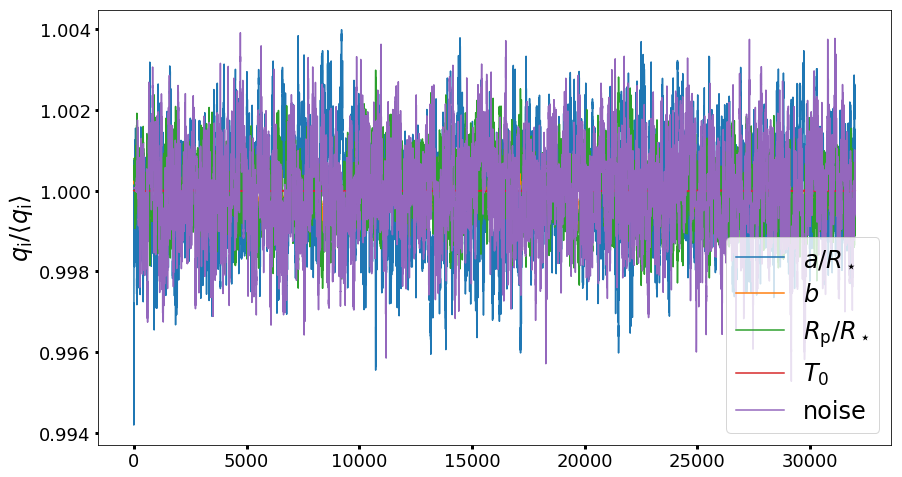

In [31]:
a_chain = np.array(new_transit_out.flatchain['a']).reshape((nwalkers, nsteps)).transpose()
mean_a_chain = np.mean(a_chain, axis=1)
std_a_chain = np.std(a_chain, axis=1)

b_chain = np.array(new_transit_out.flatchain['b']).reshape((nwalkers, nsteps)).transpose()
mean_b_chain = np.mean(b_chain, axis=1)
std_b_chain = np.std(b_chain, axis=1)

p_chain = np.array(new_transit_out.flatchain['p']).reshape((nwalkers, nsteps)).transpose()
mean_p_chain = np.mean(p_chain, axis=1)
std_p_chain = np.std(p_chain, axis=1)

T0_chain = np.array(new_transit_out.flatchain['T0']).reshape((nwalkers, nsteps)).transpose()
mean_T0_chain = np.mean(T0_chain, axis=1)
std_T0_chain = np.std(T0_chain, axis=1)

noise_chain = np.array(new_transit_out.flatchain['noise']).reshape((nwalkers, nsteps)).transpose()
mean_noise_chain = np.mean(noise_chain, axis=1)
std_noise_chain = np.std(noise_chain, axis=1)

baseline_chain = np.array(new_transit_out.flatchain['baseline']).reshape((nwalkers, nsteps)).transpose()
mean_baseline_chain = np.mean(baseline_chain, axis=1)
std_baseline_chain = np.std(baseline_chain, axis=1)

fig = plt.figure(figsize=(aspect_ratio*8, 8))
ax = fig.add_subplot(111)

ax.plot(mean_a_chain/np.mean(mean_a_chain), label='$a/R_\star$')
ax.plot(mean_b_chain/np.mean(mean_b_chain), label='$b$')
ax.plot(mean_p_chain/np.mean(mean_p_chain), label='$R_{\\rm p}/R_\star$')
ax.plot(mean_T0_chain/np.mean(mean_T0_chain), label='$T_0$')
ax.plot(mean_noise_chain/np.mean(mean_noise_chain), label='noise')

ax.set_ylabel('$q_{\\rm i}/\\langle q_{\\rm i} \\rangle$', fontsize=24)
ax.tick_params(labelsize=18)
ax.legend(loc='best', fontsize=24)

/Users/bjackson/anaconda2/lib/python2.7/site-packages/emcee/autocorr.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  acf = np.fft.ifft(f * np.conjugate(f), axis=axis)[m].real


172.4812726131575
227.8357524059596
243.1716648011193
57.17913307488184
55.992893016843304
85.27917713230757


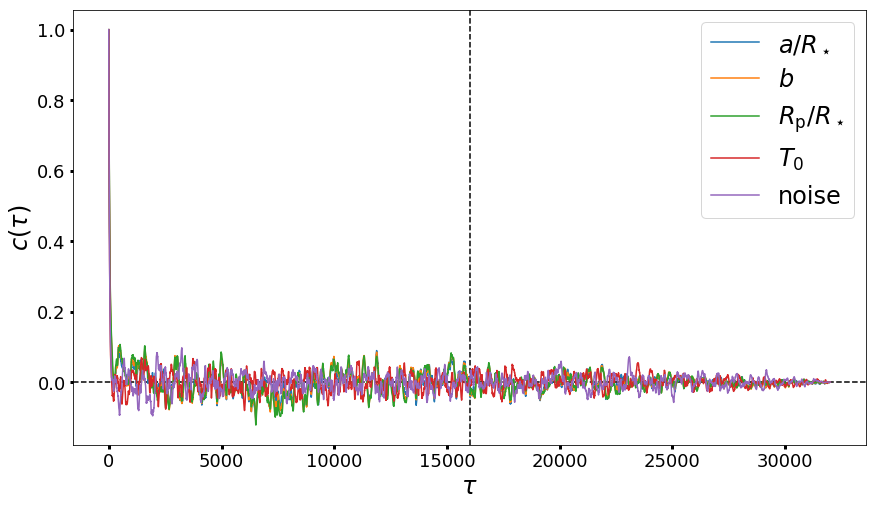

In [8]:
fig = plt.figure(figsize=(aspect_ratio*8, 8))
ax = fig.add_subplot(111)

ax.plot((function(mean_a_chain)), label='$a/R_\star$')
ax.plot((function(mean_b_chain)), label='$b$')
ax.plot((function(mean_p_chain)), label='$R_{\\rm p}/R_\star$')
ax.plot((function(mean_T0_chain)), label='$T_0$')
ax.plot((function(mean_noise_chain)), label='noise')
ax.axhline(0., color='k', ls='--', zorder=-1)

burn = 16000
ax.axvline(burn, color='k', ls='--', zorder=-1)

ax.set_xlabel('$\\tau$', fontsize=24)
ax.set_ylabel('$c\\left( \\tau \\right)$', fontsize=24)
ax.tick_params(labelsize=18)
ax.legend(loc='best', fontsize=24)

# Shorten the required number of auto-correlation times required just a bit (c = 8 instead of c = 10)
print(integrated_time(mean_a_chain, c=8))
print(integrated_time(mean_b_chain, c=8))
print(integrated_time(mean_p_chain, c=8))
print(integrated_time(mean_T0_chain, c=8))
print(integrated_time(mean_noise_chain, c=8))
print(integrated_time(mean_baseline_chain, c=8))

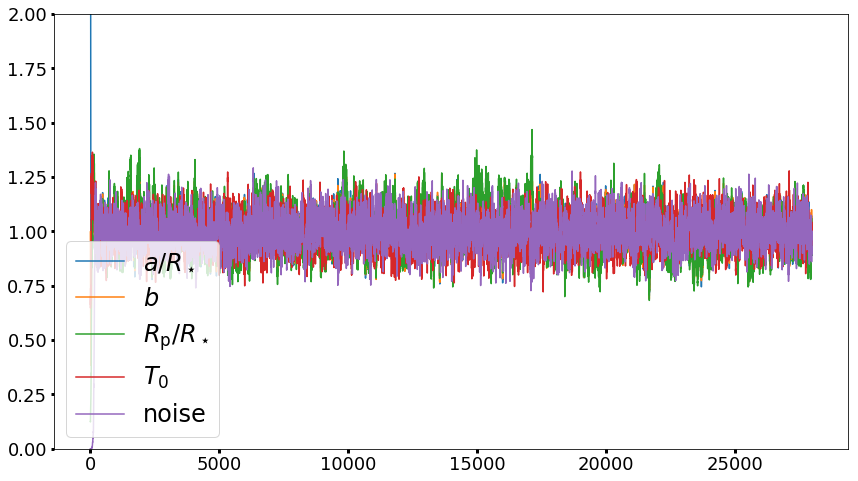

In [98]:
fig = plt.figure(figsize=(aspect_ratio*8, 8))
ax = fig.add_subplot(111)

ax.plot(std_a_chain/np.mean(std_a_chain[burn:]), label='$a/R_\star$')
ax.plot(std_b_chain/np.mean(std_b_chain[burn:]), label='$b$')
ax.plot(std_p_chain/np.mean(std_p_chain[burn:]), label='$R_{\\rm p}/R_\star$')
ax.plot(std_T0_chain/np.mean(std_T0_chain[burn:]), label='$T_0$')
ax.plot(std_noise_chain/np.mean(std_noise_chain[burn:]), label='noise')

ax.set_ylim([0, 2])

ax.tick_params(labelsize=18)
ax.legend(loc='lower left', fontsize=24)

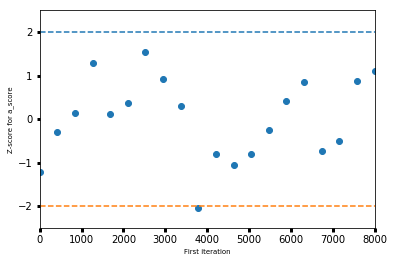

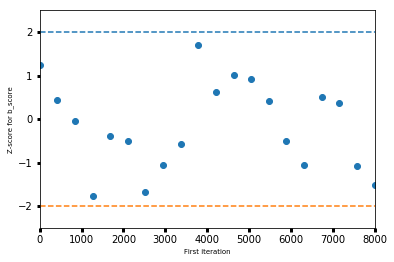

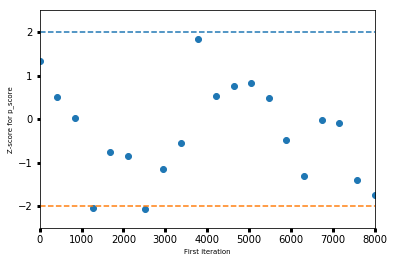

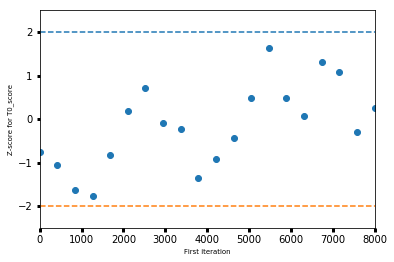

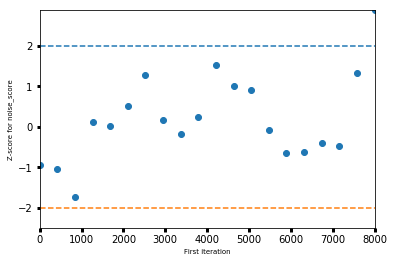

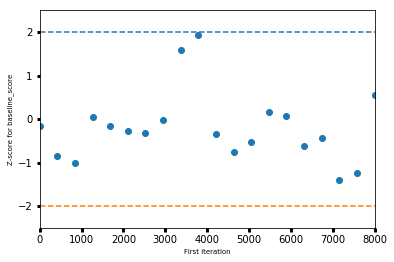

In [9]:
# 2018 Nov 16 - Attempting to use Geweke score from pyMC
mean_a_score = geweke(mean_a_chain[burn:])
geweke_plot(mean_a_score, name="a_score")

mean_b_score = geweke(mean_b_chain[burn:])
geweke_plot(mean_b_score, name="b_score")

mean_p_score = geweke(mean_p_chain[burn:])
geweke_plot(mean_p_score, name="p_score")

mean_T0_score = geweke(mean_T0_chain[burn:])
geweke_plot(mean_T0_score, name="T0_score")

mean_noise_score = geweke(mean_noise_chain[burn:])
geweke_plot(mean_noise_score, name="noise_score")

mean_baseline_score = geweke(mean_baseline_chain[burn:])
geweke_plot(mean_baseline_score, name="baseline_score")

In [9]:
# dill.dump_session("Analysis_of_Kepler76b_2018Nov28.db")
dill.load_session("Analysis_of_Kepler76b_2018Nov28.db")

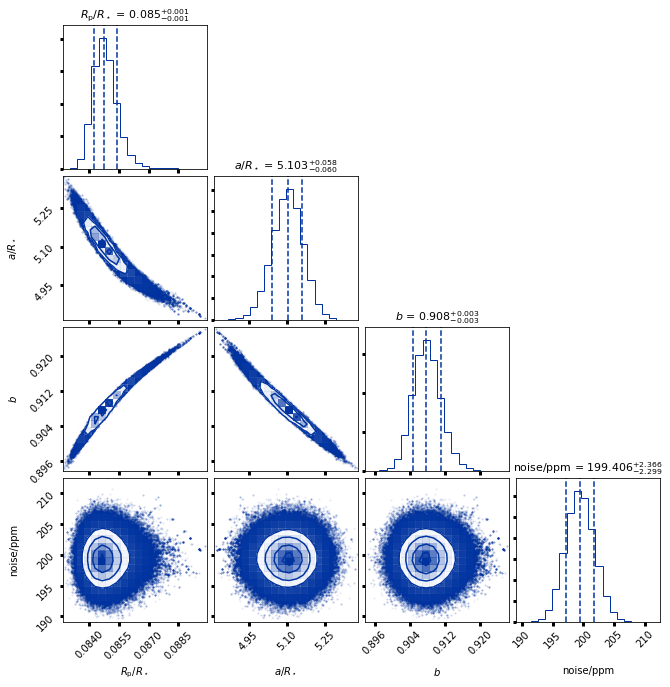

In [10]:
# 2018 Nov 9 - Make corner plot
data = np.array([p_chain[burn:].flatten(), a_chain[burn:].flatten(), b_chain[burn:].flatten(), 
                 noise_chain[burn:].flatten()*1e6]).transpose()

figure = corner.corner(data, labels=["$R_{\\rm p}/R_\star$", "$a/R_\star$", "$b$", "noise/ppm"],
                       quantiles=[0.16, 0.5, 0.84], title_fmt=".3f",
                       show_titles=True, title_kwargs={"fontsize": 11}, color=BoiseState_blue)
# figure.savefig('../folded-transit-corner-plot_Analysis-of-Kepler76b.png', dpi=500, bbox_inches='tight')

0.05735456186865482


Text(0.5,0,'Time - $T_{\\rm 0}$ (KJD)')

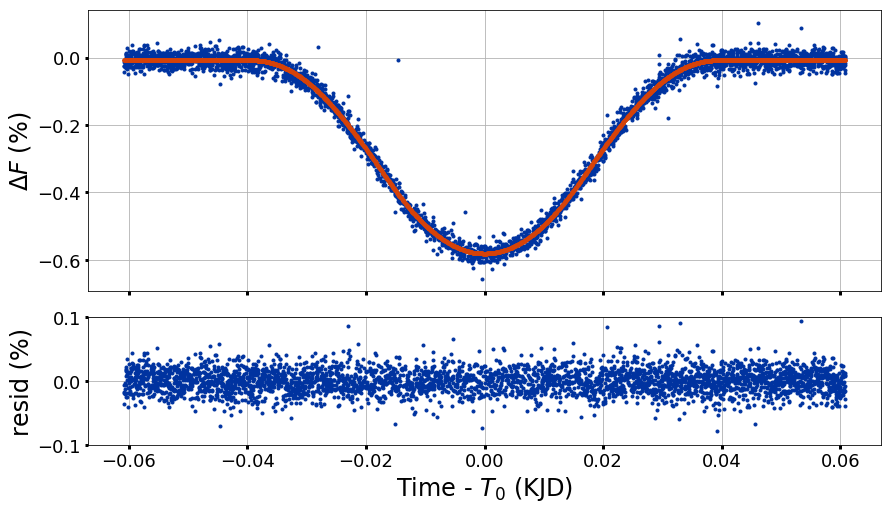

In [5]:
# 2018 Dec 5 - Make plot of best-fit transit curve and residuals
final_best_fit_transit_params = {'per': line_out.params['slope'].value, 
                                 'baseline': np.quantile(baseline_chain[burn:].flatten(), 0.5),
                                 'a': np.quantile(a_chain[burn:].flatten(), 0.5), 
                                 'T0': np.quantile(T0_chain[burn:].flatten(), 0.5),
                                 'p': np.quantile(p_chain[burn:].flatten(), 0.5), 
                                 'b': np.quantile(b_chain[burn:].flatten(), 0.5), 
                                 'linLimb': K76.coeffs[0], 
                                 'quadLimb': K76.coeffs[1]}

noise = np.quantile(noise_chain[burn:].flatten(), 0.5)

new_duration = transit_duration(final_best_fit_transit_params)
print(new_duration)

fig = plt.figure(figsize=(aspect_ratio*8, 8))

ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax1.grid(True)

ax1.set_ylabel("$\\Delta F$ (%)", fontsize=24)
ax1.tick_params('both', labelsize=18, labelbottom=False)

final_best_fit_transit_curve = fit_transit(folded_time[transit_ind], final_best_fit_transit_params)
ax1.plot(folded_time[transit_ind] - final_best_fit_transit_params['T0'], filtered_flux[transit_ind]*100., 
         marker='.', ls='', color=BoiseState_blue)
ax1.plot(folded_time[transit_ind] - final_best_fit_transit_params['T0'], final_best_fit_transit_curve*100., 
         marker='.', ls='', color=BoiseState_orange)

ax2 = plt.subplot2grid((3, 1), (2, 0), sharex=ax1)
ax2.grid(True)
ax2.plot(folded_time[transit_ind] - final_best_fit_transit_params['T0'], 
         (filtered_flux[transit_ind] - final_best_fit_transit_curve)*100., 
         marker='.', ls='', color=BoiseState_blue)
ax2.set_ylabel("resid (%)", fontsize=24)
ax2.tick_params('both', labelsize=18)
ax2.set_ylim([-0.1, 0.1])
ax2.set_xlabel("Time - $T_{\\rm 0}$ (KJD)", fontsize=24)

# fig.savefig("../final_best_fit_transit_Analysis_of_Kepler76b.png", dpi=500, bbox_inches='tight')

In [6]:
# Save all notebook results so I don't have to re-run everything every time I open the notebook.
dill.dump_session('Analysis_of_Kepler76b_2018Dec5.db')

---

2018 Dec 14<br>
Now to fit the eclipse and BEER signals together, a few orbits at a time

In [6]:
def calc_Aplanet(Abeam, Abeam_err, Asin, Asin_err, Acos, Acos_err):
    cur_Aplanet = np.sqrt((Abeam - Asin)**2 + Acos**2)
    cur_Aplanet_err = np.sqrt((Abeam - Asin)**2*(Abeam_err**2 + Asin_err**2) + Acos**2*Acos_err**2)/cur_Aplanet

    return cur_Aplanet, cur_Aplanet_err

def calc_phase_shift(Abeam, Abeam_err, Asin, Asin_err, Acos, Acos_err):
    cur_tan_phase_shift = (Abeam - Asin)/Acos    
    cur_phase_shift = np.arctan(cur_tan_phase_shift)
    
    cur_phase_shift_err = 1./(1. + cur_tan_phase_shift**2)*\
        np.sqrt(Abeam_err**2 + Asin_err**2 + (cur_tan_phase_shift/Acos)**2*Acos_err**2)

    return cur_phase_shift, cur_phase_shift_err

def calc_tan_phase_shift(Abeam, Abeam_err, Asin, Asin_err, Acos, Acos_err):
    cur_tan_phase_shift = (Abeam - Asin)/Acos    
    cur_tan_phase_shift_err = np.sqrt(Abeam_err**2 + Asin_err**2 + (cur_tan_phase_shift/Acos)**2*Acos_err**2)

    return cur_tan_phase_shift, cur_tan_phase_shift_err

Name              Value      Min      Max   Stderr     Vary     Expr Brute_Step
Acos           5.065e-05   -0.001    0.001 1.148e-06     True     None     None
Aellip         1.266e-05   -0.001    0.001 1.156e-06     True     None     None
Asin            1.1e-05     -inf      inf        0    False     None     None
T0                0.685     -inf      inf        0    False     None     None
a                 5.103     -inf      inf        0    False     None     None
b                0.9078     -inf      inf        0    False     None     None
baseline       1.733e-06   -0.001    0.001 7.705e-07     True     None     None
eclipse_depth  8.723e-05   -0.001    0.001 5.315e-06     True     None     None
per               1.545     -inf      inf        0    False     None     None
None
0.8113503020916542


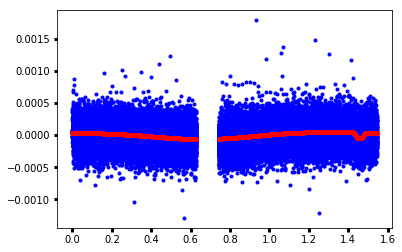

In [7]:
# Start by fitting everythign folded together

BEER_and_eclipse_params = Parameters()

# Use best-fit values from Faigler et al. (2013)
BEER_and_eclipse_params.add('per', value=final_best_fit_transit_params['per'], vary=False)
BEER_and_eclipse_params.add('a', value=final_best_fit_transit_params['a'], vary=False)
BEER_and_eclipse_params.add('b', value=final_best_fit_transit_params['b'], vary=False)
BEER_and_eclipse_params.add('T0', value=final_best_fit_transit_params['T0'], vary=False)
BEER_and_eclipse_params.add('baseline', value=0., min=-1000e-6, max=1000e-6)
BEER_and_eclipse_params.add('Aellip', value=21e-6, min=-1000e-6, max=1000e-6)
BEER_and_eclipse_params.add('eclipse_depth', value=98.9e-6, min=-1000e-6, max=1000e-6)

# BEER_and_eclipse_params.add('Abeam', value=3.8e-6, vary=False)
# BEER_and_eclipse_params.add('Aplanet', value=50.5e-6, min=-1000e-6, max=1000e-6)
# BEER_and_eclipse_params.add('phase_shift', value=-8.6/360., min=-0.25, max=0.25)

BEER_and_eclipse_params.add('Asin', value=11.e-6, vary=False)
BEER_and_eclipse_params.add('Acos', value=50.e-6, min=-1000e-6, max=1000e-6)

# Grab the out-of-transit portion
ind = ~ transit_indices(folded_time, 2.*new_duration, final_best_fit_transit_params['T0'])
time = folded_time[ind]
data = filtered_flux[ind]
err = noise*np.ones_like(time)

all_data_BEER_and_eclipse_out = minimize(residuals, BEER_and_eclipse_params, args=(time, data), 
                         kws={'eps_data': err, 'model_to_use': calc_BEER_curve})

# Rescale uncertainties using reduced chi-squared
redchi = all_data_BEER_and_eclipse_out.redchi
for cur_key in all_data_BEER_and_eclipse_out.params.keys():
    all_data_BEER_and_eclipse_out.params[cur_key].stderr *= np.sqrt(redchi)

print(all_data_BEER_and_eclipse_out.params.pretty_print())
print(all_data_BEER_and_eclipse_out.redchi)

BEER_and_eclipse_model = calc_BEER_curve(time, all_data_BEER_and_eclipse_out.params)

# Using the Abeam value suggested by Faigler et al's RV measurements, calculate Aplanet, Abeam, and phase_shift
#   KRV = 0.308 ± 0.020 km/s 
Kz = 0.308/c.to('km/s').value
Kz_err = 0.02/c.to('km/s').value
#   alpha_beam = 0.92 ± 0.04
alpha_beam = 0.92
alpha_beam_err = 0.04
# From Jackson et al. (2012) -- Abeam = alpha_beam 4 (KRV/c)
Abeam = alpha_beam*4.*Kz
Abeam_err = Abeam*np.sqrt((alpha_beam_err/alpha_beam)**2 + (Kz_err/Kz)**2)

Aplanet, Aplanet_err = calc_Aplanet(Abeam, Abeam_err, 
                                    all_data_BEER_and_eclipse_out.params['Asin'].value, 
                                    all_data_BEER_and_eclipse_out.params['Asin'].stderr, 
                                    all_data_BEER_and_eclipse_out.params['Acos'].value, 
                                    all_data_BEER_and_eclipse_out.params['Acos'].stderr)

phase_shift, phase_shift_err = calc_phase_shift(Abeam, Abeam_err, 
                                                all_data_BEER_and_eclipse_out.params['Asin'].value, 
                                                all_data_BEER_and_eclipse_out.params['Asin'].stderr, 
                                                all_data_BEER_and_eclipse_out.params['Acos'].value, 
                                                all_data_BEER_and_eclipse_out.params['Acos'].stderr)

tan_phase_shift, tan_phase_shift_err = calc_tan_phase_shift(Abeam, Abeam_err, 
                                                           all_data_BEER_and_eclipse_out.params['Asin'].value, 
                                                           all_data_BEER_and_eclipse_out.params['Asin'].stderr, 
                                                           all_data_BEER_and_eclipse_out.params['Acos'].value, 
                                                           all_data_BEER_and_eclipse_out.params['Acos'].stderr)

plt.plot(time, data, 'b.')
plt.plot(time, BEER_and_eclipse_model, 'r.')

In [8]:
def fit_all_BEER_and_eclipse_params(ret, folded_time=folded_time, filtered_flux=filtered_flux,
                                    cur_noise=noise, transit_params=final_best_fit_transit_params, min_eclipse_points=0):

    mid_times = np.array([])
    BEER_and_eclipse_params = Parameters()

    # Use best-fit values from Faigler et al. (2013)
    BEER_and_eclipse_params.add('per', value=transit_params['per'], vary=False)
    BEER_and_eclipse_params.add('a', value=transit_params['a'], vary=False)
    BEER_and_eclipse_params.add('b', value=transit_params['b'], vary=False)
    BEER_and_eclipse_params.add('T0', value=transit_params['T0'], vary=False)
    BEER_and_eclipse_params.add('baseline', value=0., min=-1000e-6, max=1000e-6)
    BEER_and_eclipse_params.add('Aellip', value=21e-6, min=-1000e-6, max=1000e-6)
    BEER_and_eclipse_params.add('eclipse_depth', value=98.9e-6, min=-1000e-6, max=1000e-6)

    # BEER_and_eclipse_params.add('Abeam', value=3.8e-6, vary=False)
    # BEER_and_eclipse_params.add('Aplanet', value=50.5e-6, min=-1000e-6, max=1000e-6)
    # BEER_and_eclipse_params.add('phase_shift', value=-8.6/360., min=-0.25, max=0.25)

    BEER_and_eclipse_params.add('Asin', value=11.e-6, min=-1000e-6, max=1000e-6)
    BEER_and_eclipse_params.add('Acos', value=50.e-6, min=-1000e-6, max=1000e-6)

    BEER_and_eclipse_outs = {}

    for cur_key in ret.keys():
        time = folded_time[ret[cur_key]]
        data = filtered_flux[ret[cur_key]]

        # Grab the out-of-transit portion
        ind = ~transit_indices(time, 2.*new_duration, transit_params['T0'])
        time = time[ind]
        data = data[ind]
        err = cur_noise*np.ones_like(time)

        # And then check that there ARE points in eclipse
        ind = transit_indices(time, new_duration, transit_params['T0'] + 0.5*transit_params['per'])
        if(time[ind].size <= min_eclipse_points):
            continue
        
        BEER_and_eclipse_out = minimize(residuals, BEER_and_eclipse_params, args=(time, data), 
                                 kws={'eps_data': err, 'model_to_use': calc_BEER_curve})

        # Make sure you don't have anomalous uncertainties
        OK_stderrs = [BEER_and_eclipse_out.params[another_key].stderr >=\
                      all_data_BEER_and_eclipse_out.params[another_key].stderr
                      for another_key in all_data_BEER_and_eclipse_out.params.keys()]
    
        if((BEER_and_eclipse_out.redchi is not None) and all(OK_stderrs)):
            for another_key in BEER_and_eclipse_out.params.keys():
                BEER_and_eclipse_out.params[another_key].stderr *= np.sqrt(BEER_and_eclipse_out.redchi)

            mid_times = np.append(mid_times, cur_key)
            BEER_and_eclipse_outs[cur_key] = BEER_and_eclipse_out

    return mid_times, BEER_and_eclipse_outs

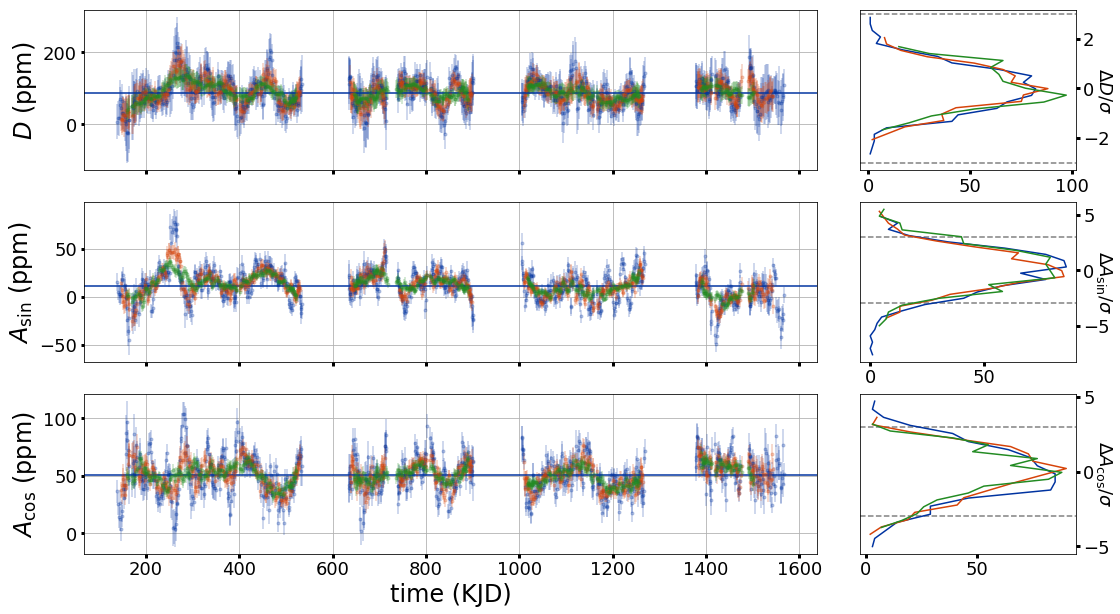

In [48]:
# Look at planetary phase curve
fig = plt.figure(figsize=(aspect_ratio*10, 10))
ax1 = plt.subplot2grid((3, 4), (0, 0), colspan=3)
ax2 = plt.subplot2grid((3, 4), (1, 0), colspan=3, sharex=ax1)
ax3 = plt.subplot2grid((3, 4), (2, 0), colspan=3, sharex=ax1)

ax1a = plt.subplot2grid((3, 4), (0, 3))
ax2a = plt.subplot2grid((3, 4), (1, 3))
ax3a = plt.subplot2grid((3, 4), (2, 3))

num_orbits_arr = [10, 20, 40]
colors = [BoiseState_blue, BoiseState_orange, 'forestgreen']

for i in range(len(num_orbits_arr)):
    num_orbits = num_orbits_arr[i]
    color = colors[i]
    
    ret = stack_orbits(final_best_fit_transit_params['per'], filtered_time, 
                       num_orbits=num_orbits, min_orbits_to_fold=np.ceil(num_orbits/2))

    mid_times, BEER_and_eclipse_outs = fit_all_BEER_and_eclipse_params(ret)

    Aplanets = np.array([])
    Aplanet_errs = np.array([])
    
    phase_shifts = np.array([])
    phase_shift_errs = np.array([])
    
    tan_phase_shifts = np.array([])
    tan_phase_shift_errs = np.array([])

    Asins = np.array([])
    Asin_errs = np.array([])

    Acoss = np.array([])
    Acos_errs = np.array([])

    for cur_key in mid_times:
        cur_Aplanet, cur_Aplanet_err = calc_Aplanet(Abeam, Abeam_err, 
                                                    BEER_and_eclipse_outs[cur_key].params['Asin'].value, 
                                                    BEER_and_eclipse_outs[cur_key].params['Asin'].stderr, 
                                                    BEER_and_eclipse_outs[cur_key].params['Acos'].value, 
                                                    BEER_and_eclipse_outs[cur_key].params['Acos'].stderr)
        Aplanets = np.append(Aplanets, cur_Aplanet)        
        Aplanet_errs = np.append(Aplanet_errs, cur_Aplanet_err)
        
        cur_phase_shift, cur_phase_shift_err = calc_phase_shift(Abeam, Abeam_err, 
                                                    BEER_and_eclipse_outs[cur_key].params['Asin'].value, 
                                                    BEER_and_eclipse_outs[cur_key].params['Asin'].stderr, 
                                                    BEER_and_eclipse_outs[cur_key].params['Acos'].value, 
                                                    BEER_and_eclipse_outs[cur_key].params['Acos'].stderr)
        phase_shifts = np.append(phase_shifts, cur_phase_shift/2./np.pi*360)
        phase_shift_errs = np.append(phase_shift_errs, cur_phase_shift_err/2./np.pi*360)

        cur_tan_phase_shift, cur_tan_phase_shift_err = calc_tan_phase_shift(Abeam, Abeam_err, 
                                                    BEER_and_eclipse_outs[cur_key].params['Asin'].value, 
                                                    BEER_and_eclipse_outs[cur_key].params['Asin'].stderr, 
                                                    BEER_and_eclipse_outs[cur_key].params['Acos'].value, 
                                                    BEER_and_eclipse_outs[cur_key].params['Acos'].stderr)
        tan_phase_shifts = np.append(tan_phase_shifts, cur_tan_phase_shift)
        tan_phase_shift_errs = np.append(tan_phase_shift_errs, cur_tan_phase_shift_err)

        eclipse_depths = np.array([BEER_and_eclipse_outs[cur_key].params['eclipse_depth'].value 
                               for cur_key in mid_times])
        eclipse_depth_errs = np.array([BEER_and_eclipse_outs[cur_key].params['eclipse_depth'].stderr 
                               for cur_key in mid_times])

        Asins = np.array([BEER_and_eclipse_outs[cur_key].params['Asin'].value 
                               for cur_key in mid_times])
        Asin_errs = np.array([BEER_and_eclipse_outs[cur_key].params['Asin'].stderr 
                               for cur_key in mid_times])

        Acoss = np.array([BEER_and_eclipse_outs[cur_key].params['Acos'].value 
                               for cur_key in mid_times])
        Acos_errs = np.array([BEER_and_eclipse_outs[cur_key].params['Acos'].stderr 
                               for cur_key in mid_times])        
        
    x = mid_times
#     ax1.plot(x, y, 
#                 alpha=0.25, ls='', color=color, marker='.')
    ax1.errorbar(x, eclipse_depths*1e6, eclipse_depth_errs*1e6,
                alpha=0.25, ls='', color=color, marker='.')

    y = (eclipse_depths - all_data_BEER_and_eclipse_out.params['eclipse_depth'].value)/\
         np.sqrt(eclipse_depth_errs**2 + all_data_BEER_and_eclipse_out.params['eclipse_depth'].stderr**2)
    hst, edges = np.histogram(y, bins='auto')
    bins = 0.5*(edges[1:] + edges[:-1])
    ax1a.plot(hst, bins, color=color)

    y = (Asins - all_data_BEER_and_eclipse_out.params['Asin'].value)/\
             np.sqrt(Asin_errs**2 + all_data_BEER_and_eclipse_out.params['Asin'].stderr**2)
#     ax2.plot(x, y, 
#                 alpha=0.25, ls='', color=color, marker='.')
    ax2.errorbar(x, Asins*1e6, Asin_errs*1e6,
            alpha=0.25, ls='', color=color, marker='.')

    hst, edges = np.histogram(y, bins='auto')
    bins = 0.5*(edges[1:] + edges[:-1])
    ax2a.plot(hst, bins, color=color)

    y = (Acoss - all_data_BEER_and_eclipse_out.params['Acos'].value)/\
             np.sqrt(Acos_errs**2 + all_data_BEER_and_eclipse_out.params['Acos'].stderr**2)
#     ax3.plot(x, y, 
#                 alpha=0.25, ls='', color=color, marker='.')
    ax3.errorbar(x, Acoss*1e6, Acos_errs*1e6,
            alpha=0.25, ls='', color=color, marker='.')

    hst, edges = np.histogram(y, bins='auto')
    bins = 0.5*(edges[1:] + edges[:-1])
    ax3a.plot(hst, bins, color=color)

ax1.axhline(all_data_BEER_and_eclipse_out.params['eclipse_depth'].value*1e6, color=BoiseState_blue)
ax2.axhline(all_data_BEER_and_eclipse_out.params['Asin'].value*1e6, color=BoiseState_blue)
ax3.axhline(all_data_BEER_and_eclipse_out.params['Acos'].value*1e6, color=BoiseState_blue)

ax1a.axhline(-3, color='grey', ls='--', zorder=-1)
ax1a.axhline(3, color='grey', ls='--', zorder=-1)
ax2a.axhline(-3, color='grey', ls='--', zorder=-1)
ax2a.axhline(3, color='grey', ls='--', zorder=-1)
ax3a.axhline(-3, color='grey', ls='--', zorder=-1)
ax3a.axhline(3, color='grey', ls='--', zorder=-1)

ax1.tick_params('y', labelsize=18)
ax1.tick_params(labelbottom=False)
ax1.grid(True)
ax1.set_ylabel('$D$ (ppm)', fontsize=24)

ax2.tick_params('y', labelsize=18)
ax2.tick_params(labelbottom=False)
ax2.grid(True)
ax2.set_ylabel('$A_{\\rm sin}$ (ppm)', fontsize=24)

ax3.grid(True)
ax3.tick_params('both', labelsize=18)
ax3.set_xlabel('time (KJD)', fontsize=24)
ax3.set_ylabel('$A_{\\rm cos}$ (ppm)', fontsize=24)

# ax1a.tick_params(labelleft=False)
# ax2a.tick_params(labelleft=False)
# ax3a.tick_params(labelleft=False)

ax1a.tick_params(labelsize=18, left=False, right=True, labelleft=False, labelright=True)
ax1a.set_ylabel("$\\Delta D/\sigma$", fontsize=18, rotation=-90)
ax1a.yaxis.set_label_position("right")

ax2a.tick_params(labelsize=18, left=False, right=True, labelleft=False, labelright=True)
ax2a.set_ylabel("$\\Delta A_{\\rm sin}/\sigma$", fontsize=18, rotation=-90)
ax2a.yaxis.set_label_position("right")

ax3a.tick_params(labelsize=18, left=False, right=True, labelleft=False, labelright=True)
ax3a.set_ylabel("$\\Delta A_{\\rm cos}/\sigma$", fontsize=18, rotation=-90)
ax3a.yaxis.set_label_position("right")

fig.savefig("../planet-phase-curve-var_Analysis_of_Kepler76b.png", dpi=500, bbox_inches='tight')

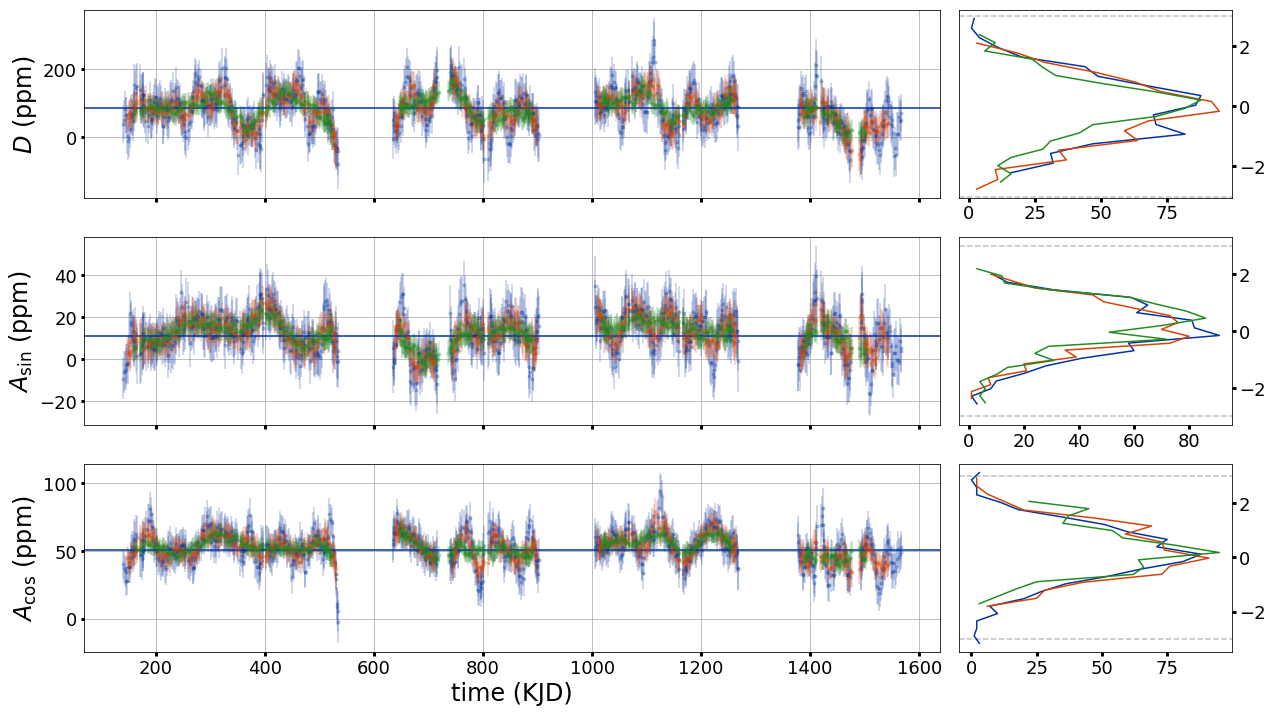

In [9]:
# Look at planetary phase curve using synthetic data!
synthetic_data = calc_BEER_curve(folded_time, all_data_BEER_and_eclipse_out.params) +\
                    noise*np.random.randn(folded_time.size)

# Look at planetary phase curve
fig = plt.figure(figsize=(aspect_ratio*10, 10))
ax1 = plt.subplot2grid((3, 4), (0, 0), colspan=3)
ax2 = plt.subplot2grid((3, 4), (1, 0), colspan=3, sharex=ax1)
ax3 = plt.subplot2grid((3, 4), (2, 0), colspan=3, sharex=ax1)

ax1a = plt.subplot2grid((3, 4), (0, 3))
ax2a = plt.subplot2grid((3, 4), (1, 3))
ax3a = plt.subplot2grid((3, 4), (2, 3))

num_orbits_arr = [10, 20, 40]
colors = [BoiseState_blue, BoiseState_orange, 'forestgreen']

for i in range(len(num_orbits_arr)):
    num_orbits = num_orbits_arr[i]
    color = colors[i]
    
    ret = stack_orbits(final_best_fit_transit_params['per'], filtered_time, 
                       num_orbits=num_orbits, min_orbits_to_fold=np.ceil(num_orbits/2))

    mid_times, BEER_and_eclipse_outs = fit_all_BEER_and_eclipse_params(ret,
                                                                      folded_time=folded_time,
                                                                      filtered_flux=synthetic_data)

    Aplanets = np.array([])
    Aplanet_errs = np.array([])
    
    phase_shifts = np.array([])
    phase_shift_errs = np.array([])
    
    tan_phase_shifts = np.array([])
    tan_phase_shift_errs = np.array([])

    Asins = np.array([])
    Asin_errs = np.array([])

    Acoss = np.array([])
    Acos_errs = np.array([])

    for cur_key in mid_times:
        cur_Aplanet, cur_Aplanet_err = calc_Aplanet(Abeam, Abeam_err, 
                                                    BEER_and_eclipse_outs[cur_key].params['Asin'].value, 
                                                    BEER_and_eclipse_outs[cur_key].params['Asin'].stderr, 
                                                    BEER_and_eclipse_outs[cur_key].params['Acos'].value, 
                                                    BEER_and_eclipse_outs[cur_key].params['Acos'].stderr)
        Aplanets = np.append(Aplanets, cur_Aplanet)        
        Aplanet_errs = np.append(Aplanet_errs, cur_Aplanet_err)
        
        cur_phase_shift, cur_phase_shift_err = calc_phase_shift(Abeam, Abeam_err, 
                                                    BEER_and_eclipse_outs[cur_key].params['Asin'].value, 
                                                    BEER_and_eclipse_outs[cur_key].params['Asin'].stderr, 
                                                    BEER_and_eclipse_outs[cur_key].params['Acos'].value, 
                                                    BEER_and_eclipse_outs[cur_key].params['Acos'].stderr)
        phase_shifts = np.append(phase_shifts, cur_phase_shift/2./np.pi*360)
        phase_shift_errs = np.append(phase_shift_errs, cur_phase_shift_err/2./np.pi*360)

        cur_tan_phase_shift, cur_tan_phase_shift_err = calc_tan_phase_shift(Abeam, Abeam_err, 
                                                    BEER_and_eclipse_outs[cur_key].params['Asin'].value, 
                                                    BEER_and_eclipse_outs[cur_key].params['Asin'].stderr, 
                                                    BEER_and_eclipse_outs[cur_key].params['Acos'].value, 
                                                    BEER_and_eclipse_outs[cur_key].params['Acos'].stderr)
        tan_phase_shifts = np.append(tan_phase_shifts, cur_tan_phase_shift)
        tan_phase_shift_errs = np.append(tan_phase_shift_errs, cur_tan_phase_shift_err)

        eclipse_depths = np.array([BEER_and_eclipse_outs[cur_key].params['eclipse_depth'].value 
                               for cur_key in mid_times])
        eclipse_depth_errs = np.array([BEER_and_eclipse_outs[cur_key].params['eclipse_depth'].stderr 
                               for cur_key in mid_times])

        Asins = np.array([BEER_and_eclipse_outs[cur_key].params['Asin'].value 
                               for cur_key in mid_times])
        Asin_errs = np.array([BEER_and_eclipse_outs[cur_key].params['Asin'].stderr 
                               for cur_key in mid_times])

        Acoss = np.array([BEER_and_eclipse_outs[cur_key].params['Acos'].value 
                               for cur_key in mid_times])
        Acos_errs = np.array([BEER_and_eclipse_outs[cur_key].params['Acos'].stderr 
                               for cur_key in mid_times])        
        
    x = mid_times
#     ax1.plot(x, y, 
#                 alpha=0.25, ls='', color=color, marker='.')
    ax1.errorbar(x, eclipse_depths*1e6, eclipse_depth_errs*1e6,
                alpha=0.25, ls='', color=color, marker='.')

    y = (eclipse_depths - all_data_BEER_and_eclipse_out.params['eclipse_depth'].value)/\
         np.sqrt(eclipse_depth_errs**2 + all_data_BEER_and_eclipse_out.params['eclipse_depth'].stderr**2)
    hst, edges = np.histogram(y, bins='auto')
    bins = 0.5*(edges[1:] + edges[:-1])
    ax1a.plot(hst, bins, color=color)

    y = (Asins - all_data_BEER_and_eclipse_out.params['Asin'].value)/\
             np.sqrt(Asin_errs**2 + all_data_BEER_and_eclipse_out.params['Asin'].stderr**2)
#     ax2.plot(x, y, 
#                 alpha=0.25, ls='', color=color, marker='.')
    ax2.errorbar(x, Asins*1e6, Asin_errs*1e6,
            alpha=0.25, ls='', color=color, marker='.')

    hst, edges = np.histogram(y, bins='auto')
    bins = 0.5*(edges[1:] + edges[:-1])
    ax2a.plot(hst, bins, color=color)

    y = (Acoss - all_data_BEER_and_eclipse_out.params['Acos'].value)/\
             np.sqrt(Acos_errs**2 + all_data_BEER_and_eclipse_out.params['Acos'].stderr**2)
#     ax3.plot(x, y, 
#                 alpha=0.25, ls='', color=color, marker='.')
    ax3.errorbar(x, Acoss*1e6, Acos_errs*1e6,
            alpha=0.25, ls='', color=color, marker='.')

    hst, edges = np.histogram(y, bins='auto')
    bins = 0.5*(edges[1:] + edges[:-1])
    ax3a.plot(hst, bins, color=color)

ax1.axhline(all_data_BEER_and_eclipse_out.params['eclipse_depth'].value*1e6, color=BoiseState_blue)
ax2.axhline(all_data_BEER_and_eclipse_out.params['Asin'].value*1e6, color=BoiseState_blue)
ax3.axhline(all_data_BEER_and_eclipse_out.params['Acos'].value*1e6, color=BoiseState_blue)

ax1a.axhline(-3, color='k', alpha=0.25, ls='--', zorder=-1)
ax1a.axhline(3, color='k', alpha=0.25, ls='--', zorder=-1)
ax2a.axhline(-3, color='k', alpha=0.25, ls='--', zorder=-1)
ax2a.axhline(3, color='k', alpha=0.25, ls='--', zorder=-1)
ax3a.axhline(-3, color='k', alpha=0.25, ls='--', zorder=-1)
ax3a.axhline(3, color='k', alpha=0.25, ls='--', zorder=-1)

ax1.tick_params('y', labelsize=18)
ax1.tick_params(labelbottom=False)
ax1.grid(True)
ax1.set_ylabel('$D$ (ppm)', fontsize=24)

ax2.tick_params('y', labelsize=18)
ax2.tick_params(labelbottom=False)
ax2.grid(True)
ax2.set_ylabel('$A_{\\rm sin}$ (ppm)', fontsize=24)

ax3.grid(True)
ax3.tick_params('both', labelsize=18)
ax3.set_xlabel('time (KJD)', fontsize=24)
ax3.set_ylabel('$A_{\\rm cos}$ (ppm)', fontsize=24)

# ax1a.tick_params(labelleft=False)
# ax2a.tick_params(labelleft=False)
# ax3a.tick_params(labelleft=False)

ax1a.tick_params(labelsize=18, left=False, right=True, labelleft=False, labelright=True)
ax2a.tick_params(labelsize=18, left=False, right=True, labelleft=False, labelright=True)
ax3a.tick_params(labelsize=18, left=False, right=True, labelleft=False, labelright=True)

plt.tight_layout()

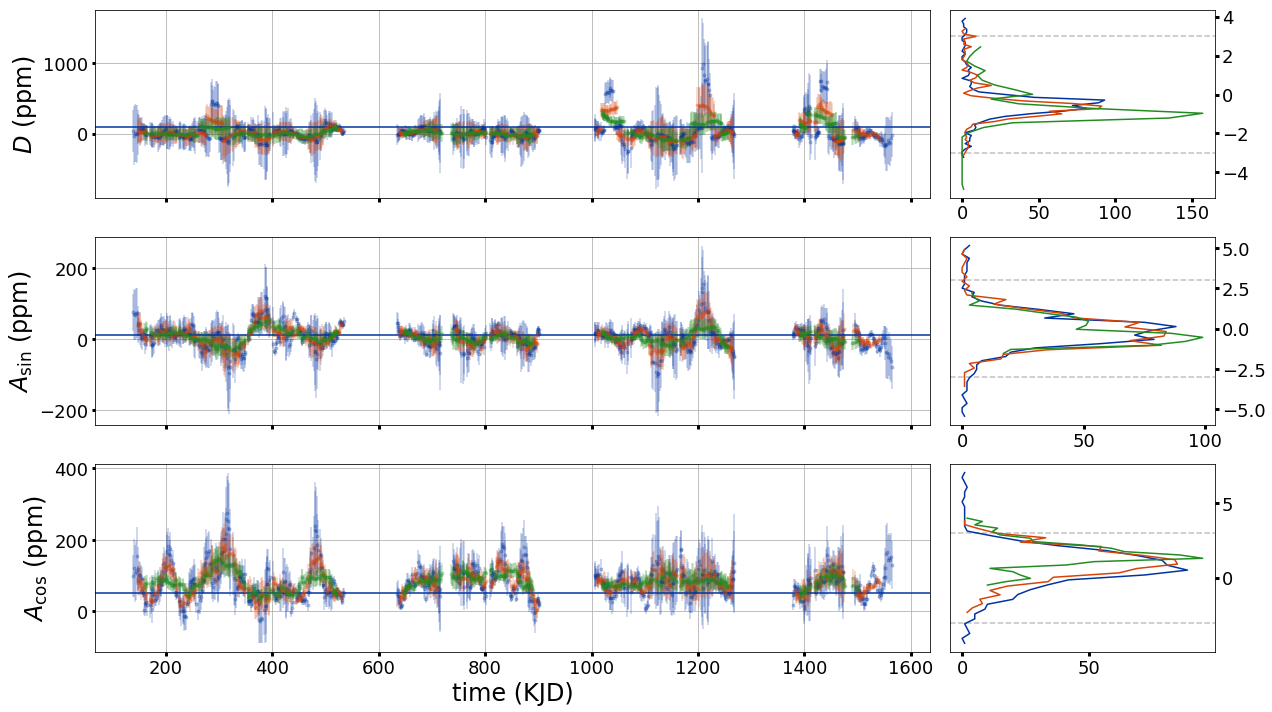

In [85]:
# 2018 Dec 29 - Scramble order of the orbits
ret = stack_orbits(final_best_fit_transit_params['per'], filtered_time, num_orbits=1, min_orbits_to_fold=0)

keys = sorted(ret.keys())
keys = [cur_key for cur_key in keys if ~np.isnan(cur_key)]
scrambled_keys = np.copy(keys)
np.random.shuffle(scrambled_keys)

scrambled_time = np.array([])
scrambled_flux = np.array([])

for i in range(len(keys)):

    a_ind = np.array(range(len(ret[keys[i]])))[ret[keys[i]]]
    b_ind = np.array(range(len(ret[scrambled_keys[i]])))[ret[scrambled_keys[i]]]
    
    # Check which set of indices has the largest number of elements
    count = range(len(a_ind))
    if(len(b_ind) < len(a_ind)):
        count = range(len(b_ind))
        
    a_ind = a_ind[count]
    b_ind = b_ind[count]
    
    scrambled_time = np.append(scrambled_time, filtered_time[a_ind])
    scrambled_flux = np.append(scrambled_flux, filtered_flux[b_ind])
    
folded_scrambled_time = scrambled_time % final_best_fit_transit_params['per']

# Look at planetary phase curve
fig = plt.figure(figsize=(aspect_ratio*10, 10))
ax1 = plt.subplot2grid((3, 4), (0, 0), colspan=3)
ax2 = plt.subplot2grid((3, 4), (1, 0), colspan=3, sharex=ax1)
ax3 = plt.subplot2grid((3, 4), (2, 0), colspan=3, sharex=ax1)

ax1a = plt.subplot2grid((3, 4), (0, 3))
ax2a = plt.subplot2grid((3, 4), (1, 3))
ax3a = plt.subplot2grid((3, 4), (2, 3))

num_orbits_arr = [10, 20, 40]
colors = [BoiseState_blue, BoiseState_orange, 'forestgreen']

for i in range(len(num_orbits_arr)):
    num_orbits = num_orbits_arr[i]
    color = colors[i]
    
    ret = stack_orbits(final_best_fit_transit_params['per'], scrambled_time, 
                       num_orbits=num_orbits, min_orbits_to_fold=np.ceil(num_orbits/2))

    mid_times, BEER_and_eclipse_outs = fit_all_BEER_and_eclipse_params(ret,
                                                                      folded_time=folded_scrambled_time,
                                                                      filtered_flux=scrambled_flux)
    
    Aplanets = np.array([])
    Aplanet_errs = np.array([])
    
    phase_shifts = np.array([])
    phase_shift_errs = np.array([])
    
    tan_phase_shifts = np.array([])
    tan_phase_shift_errs = np.array([])

    Asins = np.array([])
    Asin_errs = np.array([])

    Acoss = np.array([])
    Acos_errs = np.array([])

    for cur_key in mid_times:
        cur_Aplanet, cur_Aplanet_err = calc_Aplanet(Abeam, Abeam_err, 
                                                    BEER_and_eclipse_outs[cur_key].params['Asin'].value, 
                                                    BEER_and_eclipse_outs[cur_key].params['Asin'].stderr, 
                                                    BEER_and_eclipse_outs[cur_key].params['Acos'].value, 
                                                    BEER_and_eclipse_outs[cur_key].params['Acos'].stderr)
        Aplanets = np.append(Aplanets, cur_Aplanet)        
        Aplanet_errs = np.append(Aplanet_errs, cur_Aplanet_err)
        
        cur_phase_shift, cur_phase_shift_err = calc_phase_shift(Abeam, Abeam_err, 
                                                    BEER_and_eclipse_outs[cur_key].params['Asin'].value, 
                                                    BEER_and_eclipse_outs[cur_key].params['Asin'].stderr, 
                                                    BEER_and_eclipse_outs[cur_key].params['Acos'].value, 
                                                    BEER_and_eclipse_outs[cur_key].params['Acos'].stderr)
        phase_shifts = np.append(phase_shifts, cur_phase_shift/2./np.pi*360)
        phase_shift_errs = np.append(phase_shift_errs, cur_phase_shift_err/2./np.pi*360)

        cur_tan_phase_shift, cur_tan_phase_shift_err = calc_tan_phase_shift(Abeam, Abeam_err, 
                                                    BEER_and_eclipse_outs[cur_key].params['Asin'].value, 
                                                    BEER_and_eclipse_outs[cur_key].params['Asin'].stderr, 
                                                    BEER_and_eclipse_outs[cur_key].params['Acos'].value, 
                                                    BEER_and_eclipse_outs[cur_key].params['Acos'].stderr)
        tan_phase_shifts = np.append(tan_phase_shifts, cur_tan_phase_shift)
        tan_phase_shift_errs = np.append(tan_phase_shift_errs, cur_tan_phase_shift_err)

        eclipse_depths = np.array([BEER_and_eclipse_outs[cur_key].params['eclipse_depth'].value 
                               for cur_key in mid_times])
        eclipse_depth_errs = np.array([BEER_and_eclipse_outs[cur_key].params['eclipse_depth'].stderr 
                               for cur_key in mid_times])

        Asins = np.array([BEER_and_eclipse_outs[cur_key].params['Asin'].value 
                               for cur_key in mid_times])
        Asin_errs = np.array([BEER_and_eclipse_outs[cur_key].params['Asin'].stderr 
                               for cur_key in mid_times])

        Acoss = np.array([BEER_and_eclipse_outs[cur_key].params['Acos'].value 
                               for cur_key in mid_times])
        Acos_errs = np.array([BEER_and_eclipse_outs[cur_key].params['Acos'].stderr 
                               for cur_key in mid_times])        
        
    x = mid_times
#     ax1.plot(x, y, 
#                 alpha=0.25, ls='', color=color, marker='.')
    ax1.errorbar(x, eclipse_depths*1e6, eclipse_depth_errs*1e6,
                alpha=0.25, ls='', color=color, marker='.')

    y = (eclipse_depths - all_data_BEER_and_eclipse_out.params['eclipse_depth'].value)/\
         np.sqrt(eclipse_depth_errs**2 + all_data_BEER_and_eclipse_out.params['eclipse_depth'].stderr**2)
    hst, edges = np.histogram(y, bins='auto')
    bins = 0.5*(edges[1:] + edges[:-1])
    ax1a.plot(hst, bins, color=color)

    y = (Asins - all_data_BEER_and_eclipse_out.params['Asin'].value)/\
             np.sqrt(Asin_errs**2 + all_data_BEER_and_eclipse_out.params['Asin'].stderr**2)
#     ax2.plot(x, y, 
#                 alpha=0.25, ls='', color=color, marker='.')
    ax2.errorbar(x, Asins*1e6, Asin_errs*1e6,
            alpha=0.25, ls='', color=color, marker='.')

    hst, edges = np.histogram(y, bins='auto')
    bins = 0.5*(edges[1:] + edges[:-1])
    ax2a.plot(hst, bins, color=color)

    y = (Acoss - all_data_BEER_and_eclipse_out.params['Acos'].value)/\
             np.sqrt(Acos_errs**2 + all_data_BEER_and_eclipse_out.params['Acos'].stderr**2)
#     ax3.plot(x, y, 
#                 alpha=0.25, ls='', color=color, marker='.')
    ax3.errorbar(x, Acoss*1e6, Acos_errs*1e6,
            alpha=0.25, ls='', color=color, marker='.')

    hst, edges = np.histogram(y, bins='auto')
    bins = 0.5*(edges[1:] + edges[:-1])
    ax3a.plot(hst, bins, color=color)

ax1.axhline(all_data_BEER_and_eclipse_out.params['eclipse_depth'].value*1e6, color=BoiseState_blue)
ax2.axhline(all_data_BEER_and_eclipse_out.params['Asin'].value*1e6, color=BoiseState_blue)
ax3.axhline(all_data_BEER_and_eclipse_out.params['Acos'].value*1e6, color=BoiseState_blue)

ax1a.axhline(-3, color='k', alpha=0.25, ls='--', zorder=-1)
ax1a.axhline(3, color='k', alpha=0.25, ls='--', zorder=-1)
ax2a.axhline(-3, color='k', alpha=0.25, ls='--', zorder=-1)
ax2a.axhline(3, color='k', alpha=0.25, ls='--', zorder=-1)
ax3a.axhline(-3, color='k', alpha=0.25, ls='--', zorder=-1)
ax3a.axhline(3, color='k', alpha=0.25, ls='--', zorder=-1)

ax1.tick_params('y', labelsize=18)
ax1.tick_params(labelbottom=False)
ax1.grid(True)
ax1.set_ylabel('$D$ (ppm)', fontsize=24)

ax2.tick_params('y', labelsize=18)
ax2.tick_params(labelbottom=False)
ax2.grid(True)
ax2.set_ylabel('$A_{\\rm sin}$ (ppm)', fontsize=24)

ax3.grid(True)
ax3.tick_params('both', labelsize=18)
ax3.set_xlabel('time (KJD)', fontsize=24)
ax3.set_ylabel('$A_{\\rm cos}$ (ppm)', fontsize=24)

# ax1a.tick_params(labelleft=False)
# ax2a.tick_params(labelleft=False)
# ax3a.tick_params(labelleft=False)

ax1a.tick_params(labelsize=18, left=False, right=True, labelleft=False, labelright=True)
ax2a.tick_params(labelsize=18, left=False, right=True, labelleft=False, labelright=True)
ax3a.tick_params(labelsize=18, left=False, right=True, labelleft=False, labelright=True)

plt.tight_layout()

In [86]:
dill.dump_session('Analysis_of_Kepler76b_2018Dec29.db')